<a href="https://colab.research.google.com/github/PabloKarpacho/Lab-2/blob/main/%D0%BB%D0%B0%D0%B1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#imports
import numpy as np
import pandas as pd
import math
from numpy.linalg import inv, pinv

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.stats import t

In [ ]:
#fp = 'C:/Users/karpo/Downloads/EXPORT.xlsx' #Ноут путь к датасету
fp = 'C:/Users/Павел/Downloads/Telegram Desktop/данные/данные/EXPORT.xlsx' #ПК путь к датасету

# Обработка

In [ ]:
data = pd.read_excel(fp)
drop_cols = ['Кол-во в Заказах, АЕИ', 'Клиент','Тип финансирования', 'Сумма заказов с НДС', 'Тонаж по планам МТО', 'Рекв.Грузополучателя', 'Кол-во в СФ, АЕИ','СПП элемент','Статус плана МТО','Дата Сч/ф','Курс4', 'Сумма по Сч/ф с НДС (поставлено)', 'Поступило на ЦС, АЕИ','Шаг корр. ЭСД']
dates = ["Дата заявки", "Дата поставки по приложению", "Дата приложения" ,"ПервоначДатаПоставки (план МТО)","Прогнозная дата поставки" ,"Срок поставки","ПервоначДатаУтвПлМТО","Дата ФП по последней входящей поставке"]
data.sort_values(by = 'Прогнозная дата поставки', ignore_index= True, inplace = True)
data.drop([0,1,2,3,4,5,6], axis = 0 ,inplace = True)
data.drop(drop_cols, axis = 1 ,inplace = True)

data.fillna(0, inplace=True)
#data

In [ ]:
period = data['Дата ФП по последней входящей поставке'] - data['Прогнозная дата поставки']
data['Задержка поставки'] = period
data['Задержка поставки'] = data['Задержка поставки'].dt.days
data.reset_index(drop=True ,inplace = True)
data.drop(dates, axis = 1 ,inplace = True)

In [ ]:
x = data['Поставщик'].value_counts()
x = x.to_frame(name= 'Уник. поставщиков')
x.reset_index(inplace=True)
x.rename(columns={"index": 'Поставщик'}, inplace=True)

In [ ]:
data = data.merge(x, on='Поставщик' )
data = data[data['Уник. поставщиков']>1]

In [ ]:
disc_cols = ['Гр.зак.', 'Материал','Поставщик','Код класса МТР','Шаг ЭСД','Уник. поставщиков']

In [ ]:

for item in disc_cols:
  le = preprocessing.LabelEncoder()
  encoded = le.fit_transform(data[item])
  data[item] = encoded

In [ ]:
data = data[(data['Кол-во к закупу, АЕИ'] < 25000) & (data['План.сумма с НДС 18%'] < 3*10**8) & (data['Кол-во в предв. СФ, АЕИ'] < 100) & (data['Сумма (незаконтрактовано) с НДС'] > -500) & (data['Сумма (незаконтрактовано) с НДС'] < 2000) & (data['Сумма ПлЦ законтракт/непоставл с НДС'] < 3*10**7)]

In [ ]:
cont_cols = data.columns.values.tolist()
for item in disc_cols:
  cont_cols.remove(item)
cont_cols.remove('Задержка поставки')

In [ ]:
corr_df = pd.DataFrame(columns = data.columns.tolist(), index = data.columns.tolist())
pvaluesXcorrs = pd.DataFrame()
pv = []
cor = []
col = []
for i in corr_df.index.to_list(): #iterate over rows
  for j in corr_df.columns.to_list(): #iterate over columns
    if ((i in cont_cols) == True) and ((j in cont_cols) == True):
      corr_df.at[i, j] = scipy.stats.pearsonr(data[i].values,data[j].values).statistic
      if corr_df.at[i, j] > 0.5:
        pv.append(scipy.stats.pearsonr(data[i].values,data[j].values).pvalue)
        cor.append(corr_df.at[i, j])
        col.append(str(i) + ' - ' + str(j))
    else:
      corr_df.at[i, j] = scipy.stats.spearmanr(data[i].values,data[j].values).correlation
      if corr_df.at[i, j] > 0.5:
        pv.append(scipy.stats.spearmanr(data[i].values,data[j].values).pvalue)
        cor.append(corr_df.at[i, j])
        col.append(str(i) + ' - ' + str(j))



pvaluesXcorrs['Pairs'] = col
pvaluesXcorrs['Correlation'] = cor
pvaluesXcorrs['Pvalues'] = pv
pvaluesXcorrs = pvaluesXcorrs[pvaluesXcorrs['Correlation'] < 0.9 ]
pvaluesXcorrs.reset_index(drop=True, inplace=True)
corr_df = corr_df.astype(float)

In [ ]:
pvaluesXcorrs

,Pairs,Correlation,Pvalues
0,"Материал - Кол-во в предв. СФ, АЕИ",0.626225,0.000000e+00
1,Материал - Курс2,0.506346,2.619240e-214
2,"Кол-во в предв. СФ, АЕИ - Материал",0.626225,0.000000e+00
3,Курс1 - Курс3,0.795562,0.000000e+00
4,Курс2 - Материал,0.506346,2.619240e-214
5,Курс2 - Курс5,0.514296,3.621534e-222
6,Курс3 - Курс1,0.795562,0.000000e+00
7,Курс5 - Курс2,0.514296,3.621534e-222


,Pairs,Correlation,Pvalues
0,"Материал - Кол-во в предв. СФ, АЕИ",0.626225,0.000000e+00
1,Материал - Курс2,0.506346,2.619240e-214
2,"Кол-во в предв. СФ, АЕИ - Материал",0.626225,0.000000e+00
3,Курс1 - Курс3,0.795562,0.000000e+00
4,Курс2 - Материал,0.506346,2.619240e-214
5,Курс2 - Курс5,0.514296,3.621534e-222
6,Курс3 - Курс1,0.795562,0.000000e+00
7,Курс5 - Курс2,0.514296,3.621534e-222


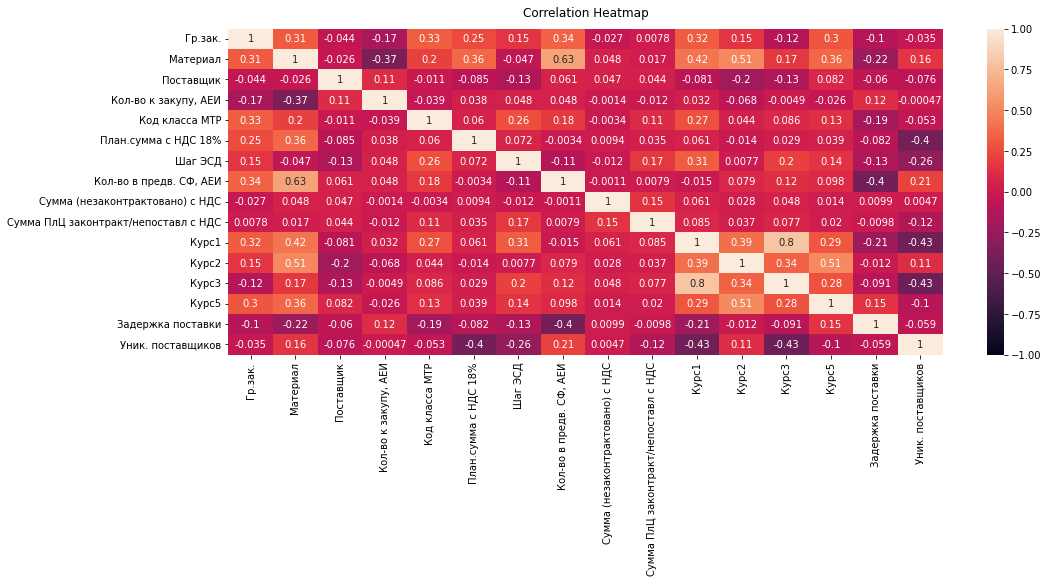

In [ ]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
pvaluesXcorrs

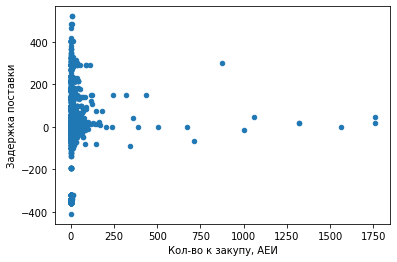

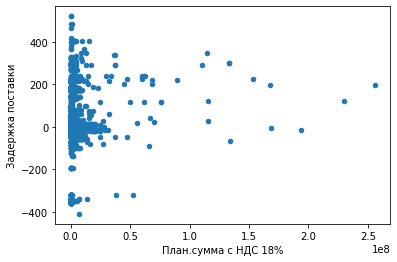

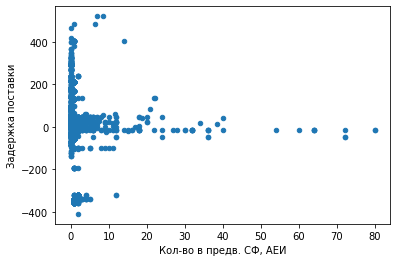

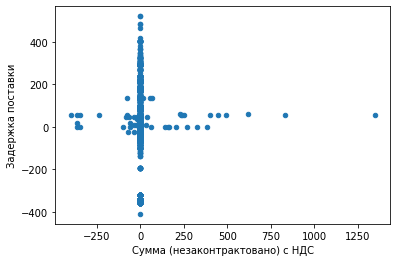

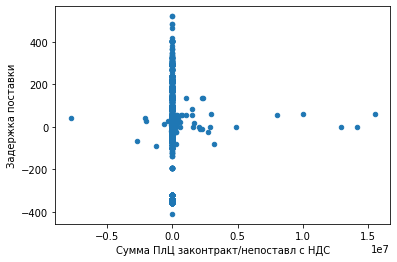

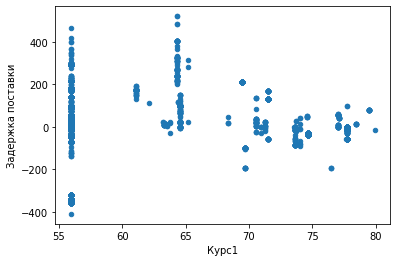

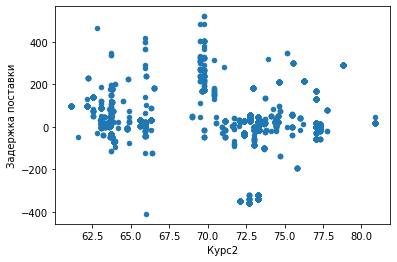

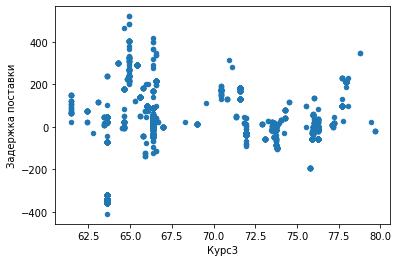

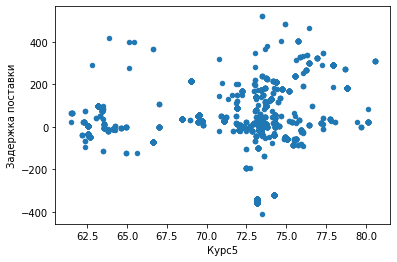

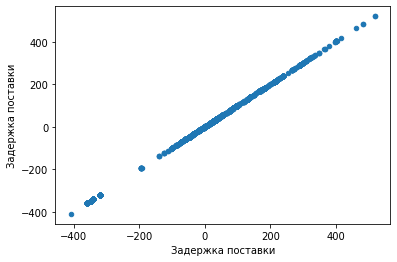

In [ ]:

for idx, feature in enumerate(cont_cols):
    data.plot(feature, "Задержка поставки", subplots=True, kind="scatter")

In [ ]:
target_cols = ['Задержка поставки']
train_cols = data.columns.values.tolist()
train_cols.remove('Задержка поставки')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[train_cols], data[target_cols], random_state=42, test_size=0.35, stratify=data['Поставщик'])
X_test.reset_index(drop=True)
y_test.reset_index(drop=True)

In [ ]:
def quantile_biplot(data, column, sample):

  # Calculation of quantiles
  percs = np.linspace(0, 100, 100)
  qn_data = np.percentile(data[column], percs)
  qn_sample  = np.percentile(sample, percs)

  # Building a quantile biplot
  x = np.linspace(np.min(data[column]), np.max(data[column]))
  plt.figure(figsize=(10, 10))
  plt.plot(qn_data, qn_sample, ls="", marker="o", markersize=6)
  plt.plot(x, x, color="k", ls="--")

  plt.xlabel(f'Распределение СВ')
  plt.ylabel('Распределение предсказаний')
  plt.title('Биплот для колонки ' + str(column))
  plt.legend()
  plt.show()

In [ ]:
def distribution_of_residuals(pred):
  residuals = y_test[target_cols] - pred
  plt.figure(figsize=(20,10))
  plt.hist(residuals, density=True, bins=17, label='Распределени остатков')
  plt.title('Распределение остатков')
  plt.xlabel('Задержка поставки')
  plt.ylabel('Probability')

In [ ]:
def confidence_interval(conf, preds):


  n = len(y_test['Задержка поставки'])
  alpha = 1 - conf
  y = y_test['Задержка поставки'].values
  student = scipy.stats.t.ppf(1 - alpha/2 , n - 2)

  Xmatrix = X_test.to_numpy()
  XTmatrix  = np.transpose(Xmatrix)
  Xmatrix = np.matrix(Xmatrix)
  XTmatrix = np.matrix(XTmatrix)
  XX = XTmatrix.dot(Xmatrix)
  invXtX = np.linalg.inv(XX)

  x = []

  for i in range(n):
    string = X_test.to_numpy()[i]
    string = np.matrix(string)
    x.append(np.sqrt(string.dot(invXtX).dot(np.transpose(string)).A[0][0]))

  x = np.array(x)
  sigma = mean_squared_error(y, preds, squared=False)*np.sqrt(n/(n-16))

  plus, minus = np.ravel(preds) + student * x * sigma, np.ravel(preds) - student * x * sigma

  return   plus, minus

# Линейная Регрессия 

In [ ]:

lr = LinearRegression()

lr.fit(X_train, y_train)

predslr = lr.predict(X_test)
rmse = mean_squared_error(y_test,predslr,squared=False)
#r2 = r2_score(y_test, preds)

print('Root mean Squared Error: {:.3f}'.format(rmse))
print('Training score: {}'.format(lr.score(X_train, y_train)))
print('Test score: {}'.format(lr.score(X_test, y_test)))

Root mean Squared Error: 124.703
Training score: 0.2808798568033921
Test score: 0.26480224748457515


In [ ]:
plus, minus = confidence_interval(0.95, predslr)

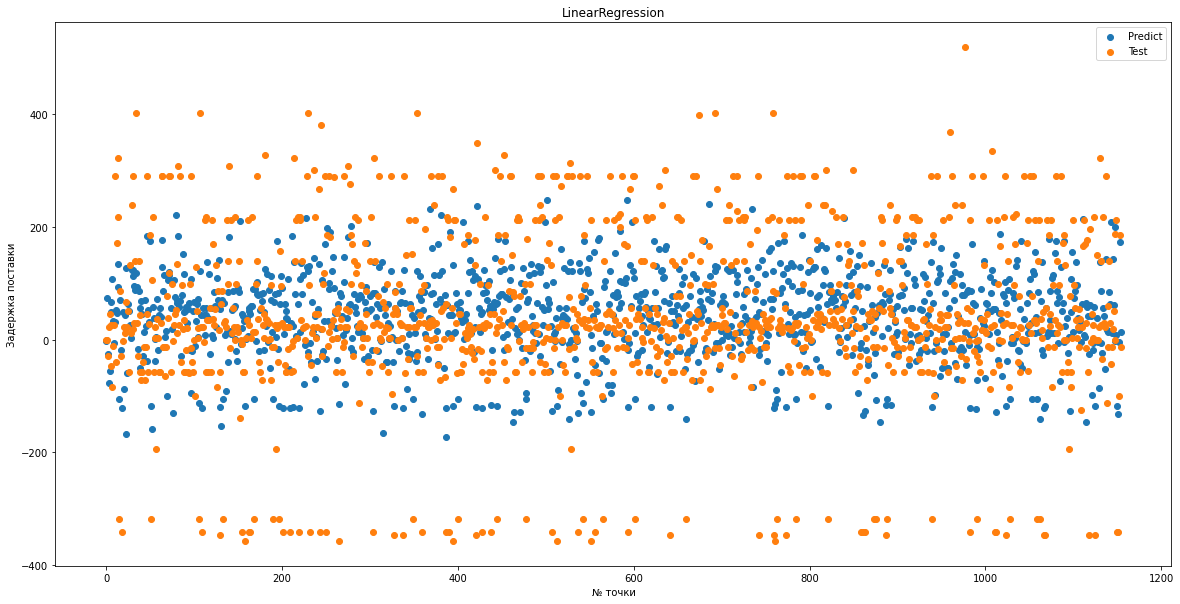

In [ ]:
x_axis = range(len(y_test))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, predslr, label='Predict')

plt.scatter(x_axis, y_test['Задержка поставки'], label='Test')

plt.xlabel('№ точки')
plt.ylabel('Задержка поставки')
plt.title('LinearRegression')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


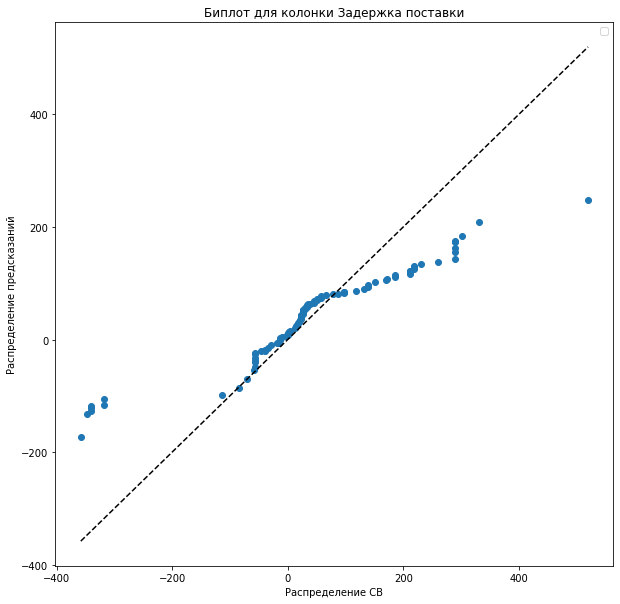

In [ ]:
quantile_biplot(y_test, 'Задержка поставки', predslr)

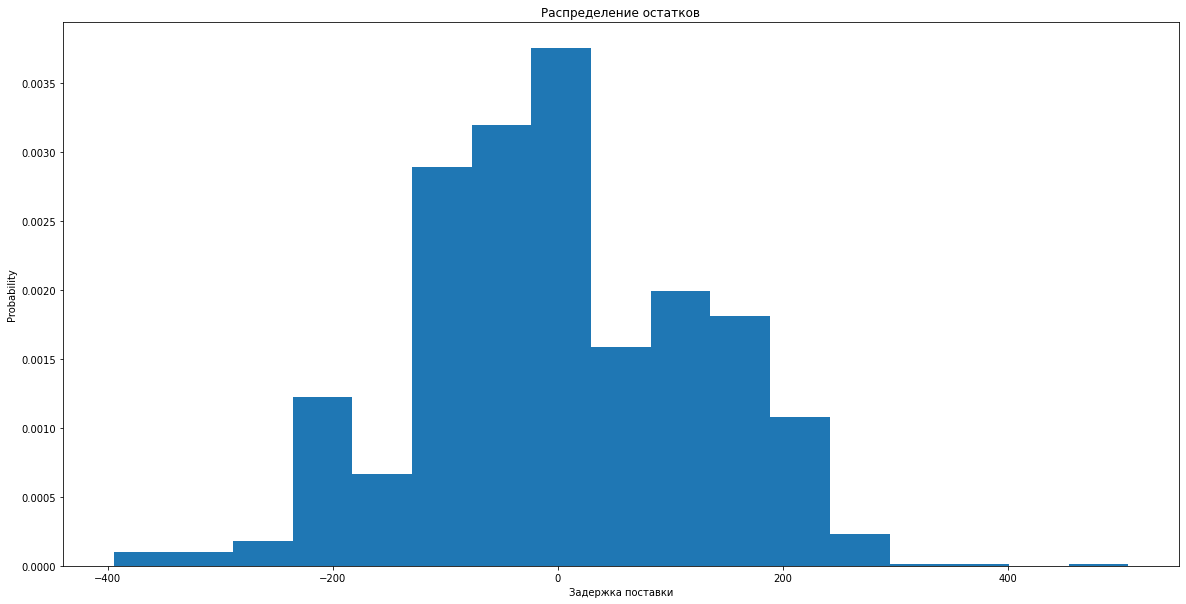

In [ ]:
distribution_of_residuals(predslr)

C:\Users\karpo\AppData\Local\Temp\ipykernel_5276\1053398324.py:4: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[item].values, plus, label = 'Confidence_interval',c = 'r',alpha=0.6, marker = "_", edgecolors ='face', plotnonfinite = True)
C:\Users\karpo\AppData\Local\Temp\ipykernel_5276\1053398324.py:5: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[item].values, minus, c = 'r',alpha=0.6, marker = "_", edgecolors ='none', plotnonfinite = True)


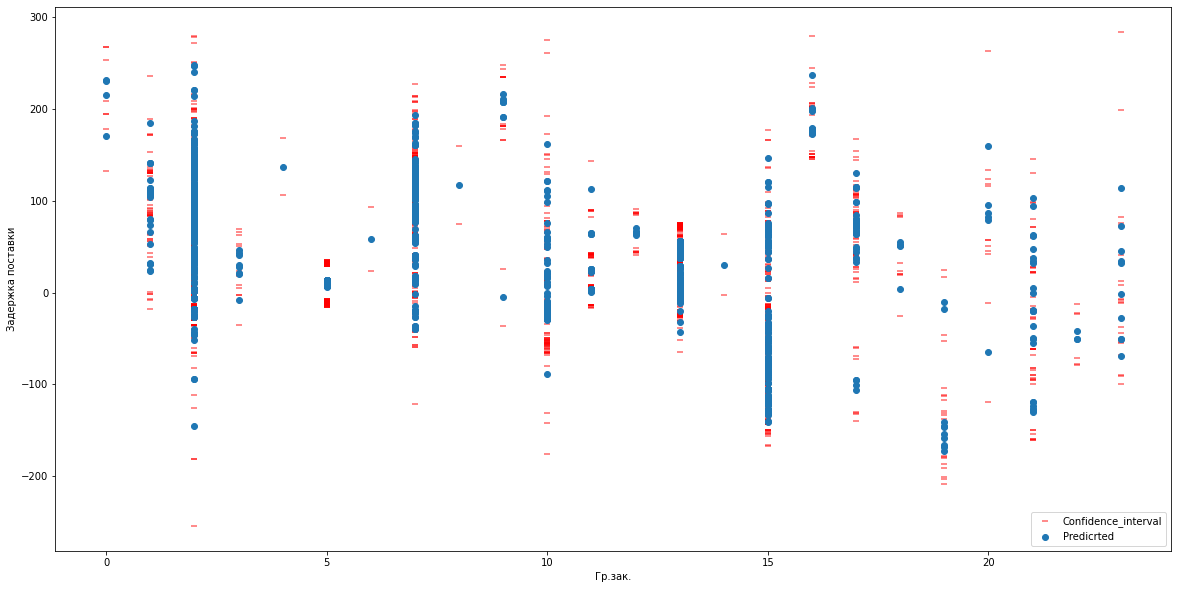

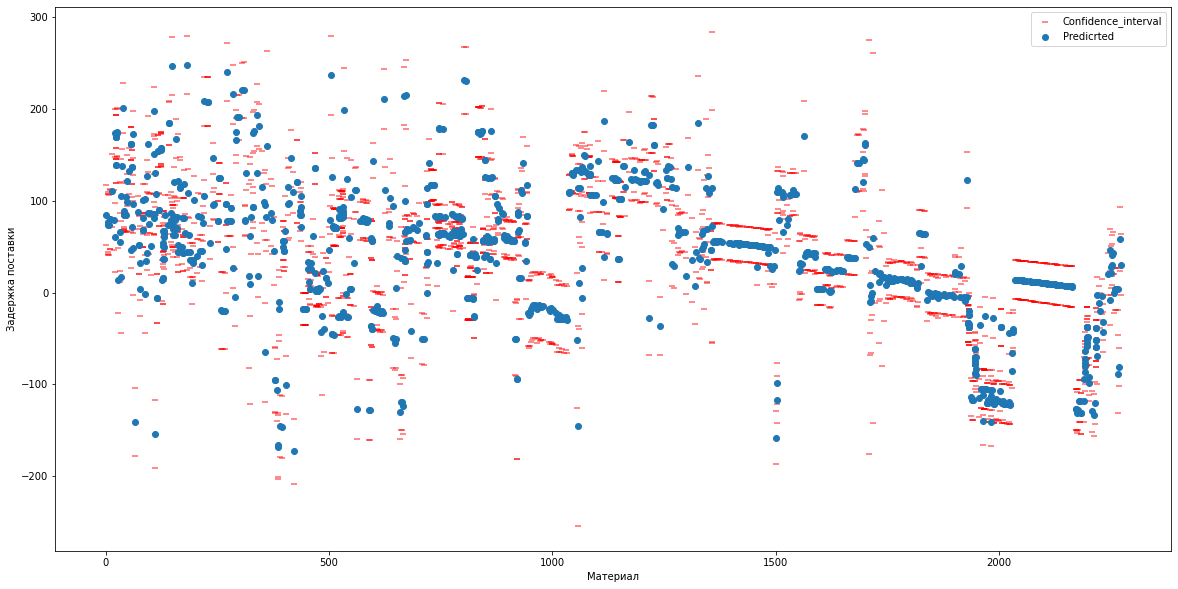

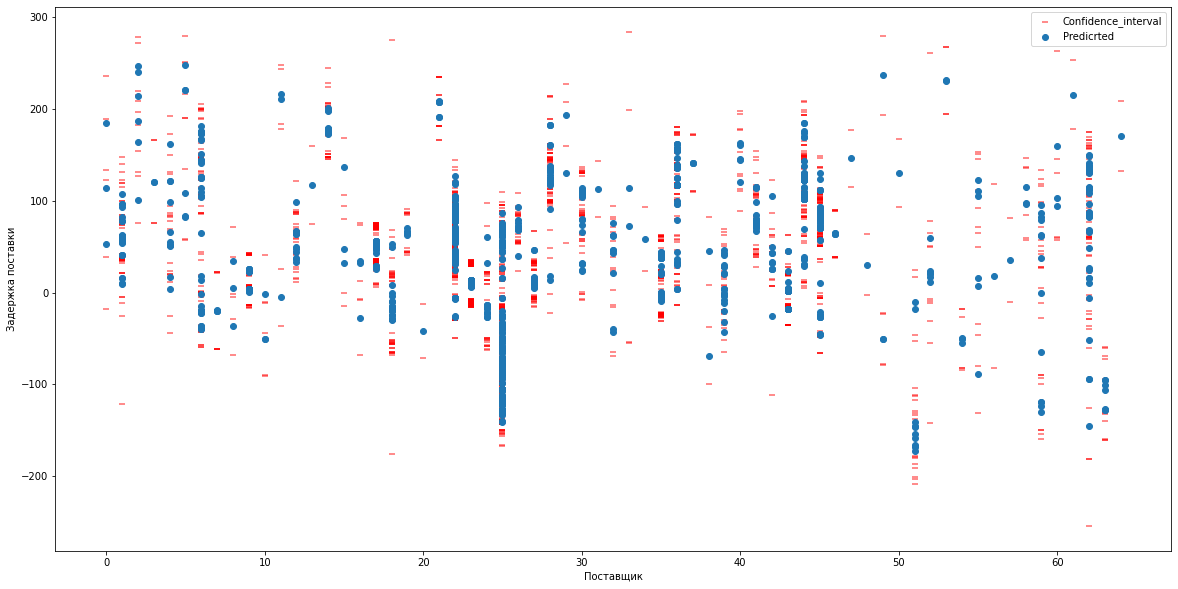

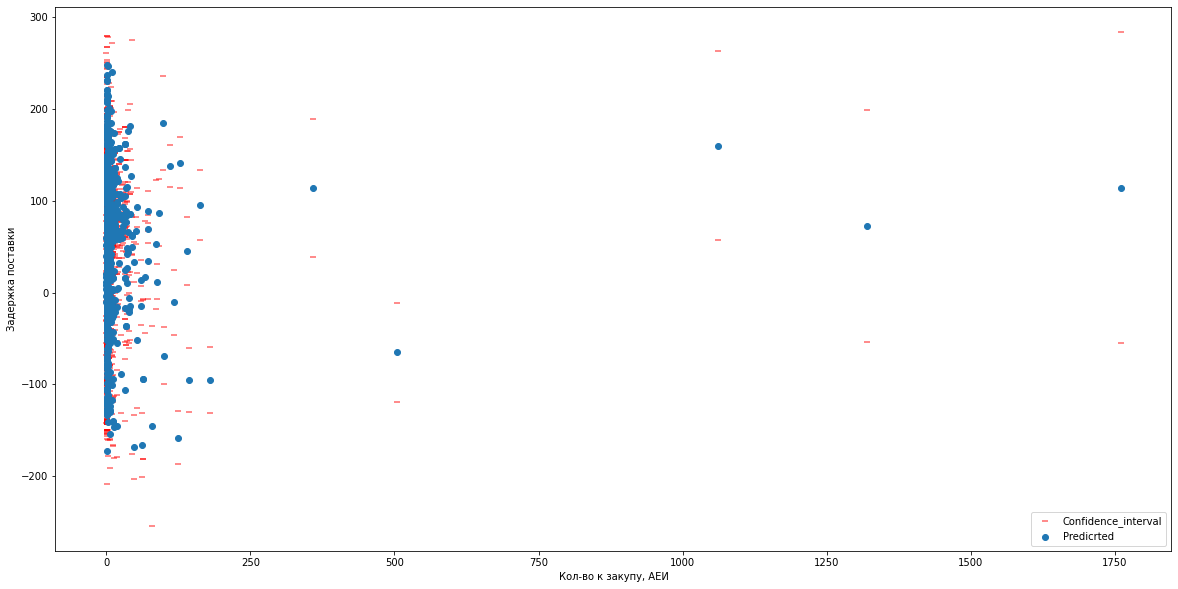

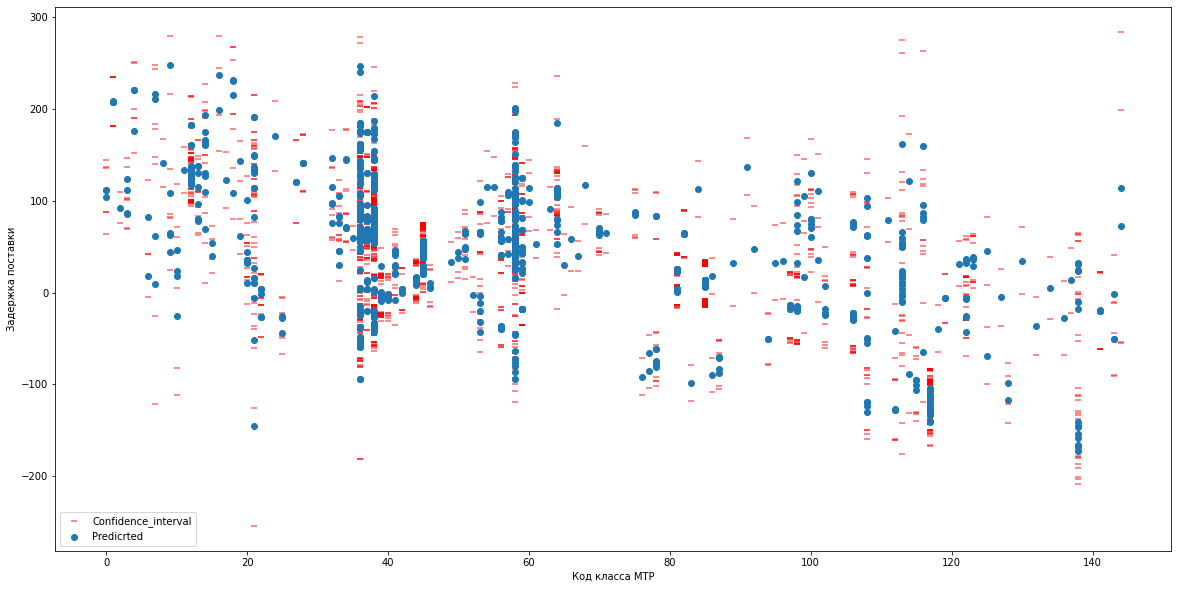

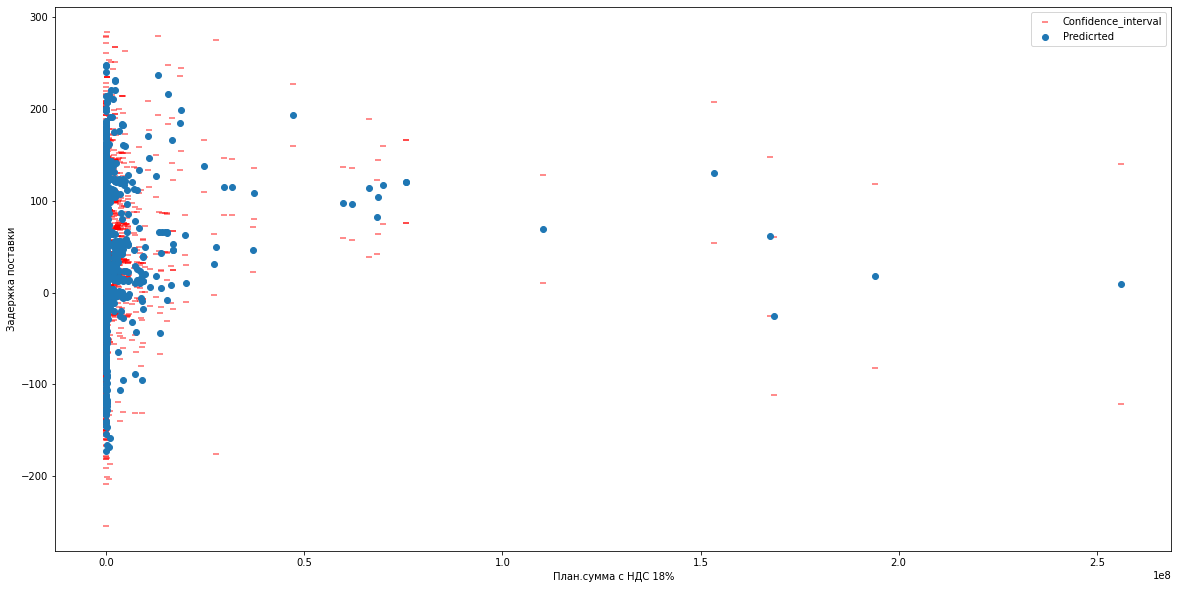

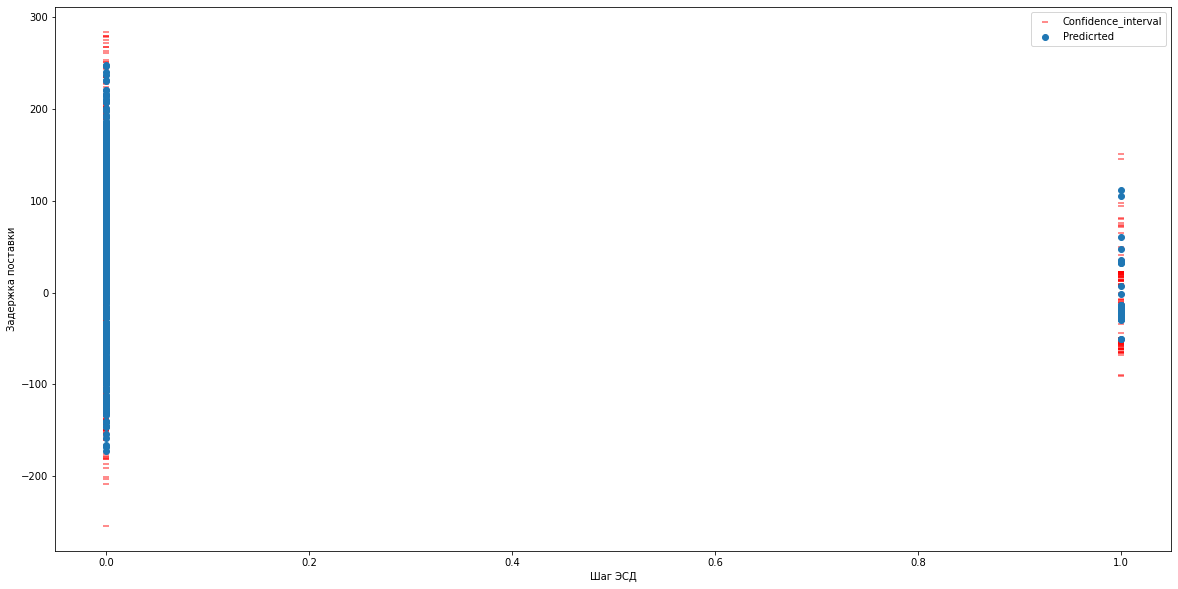

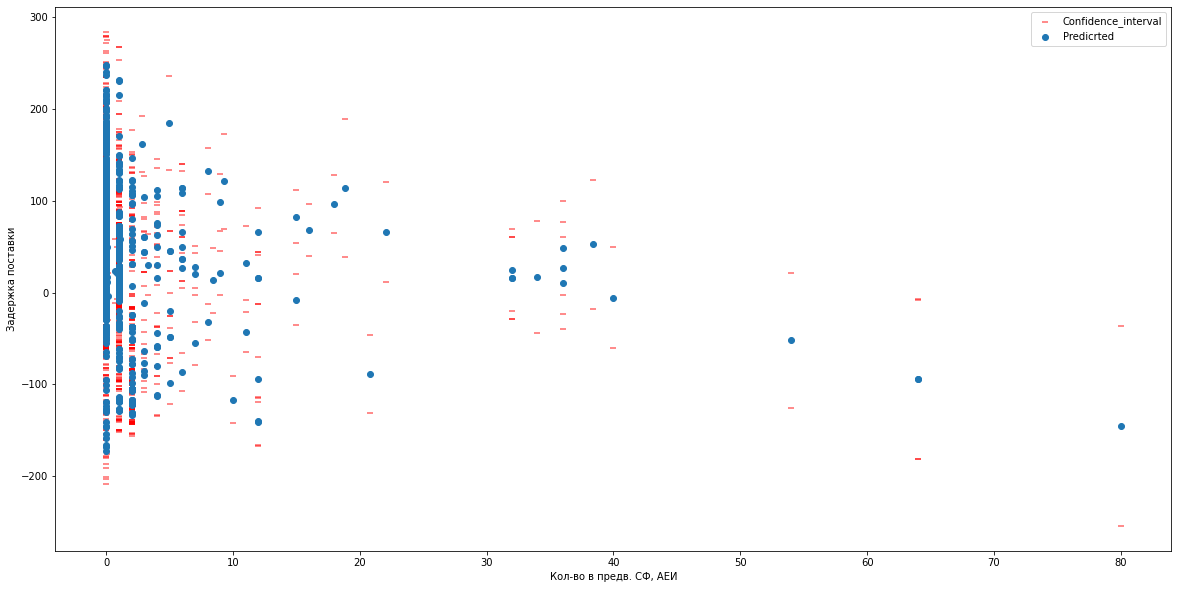

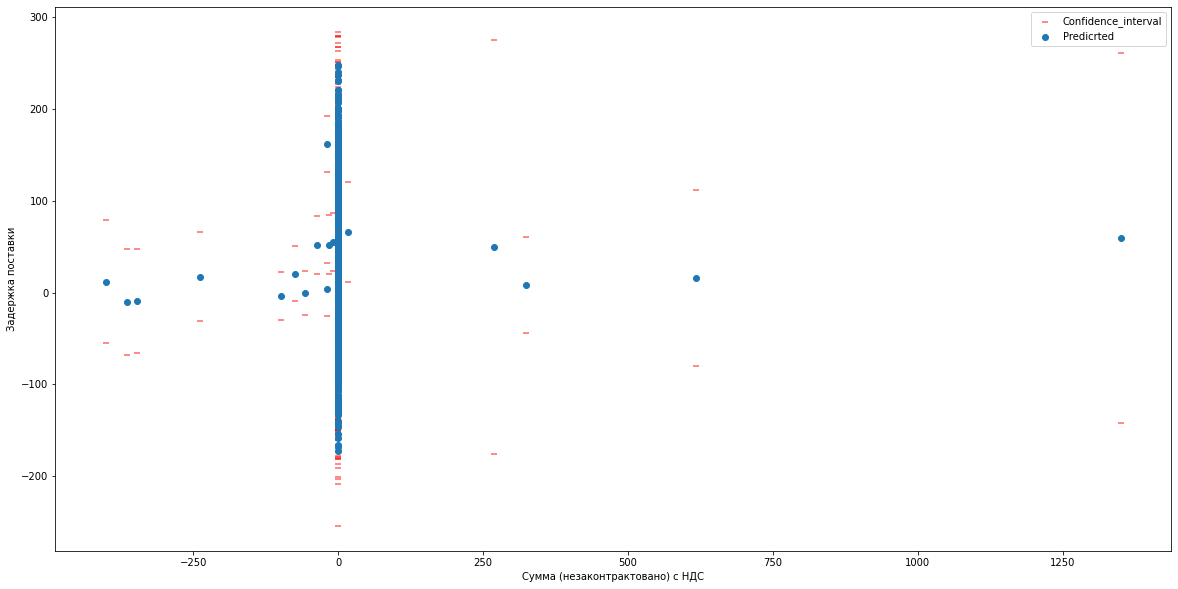

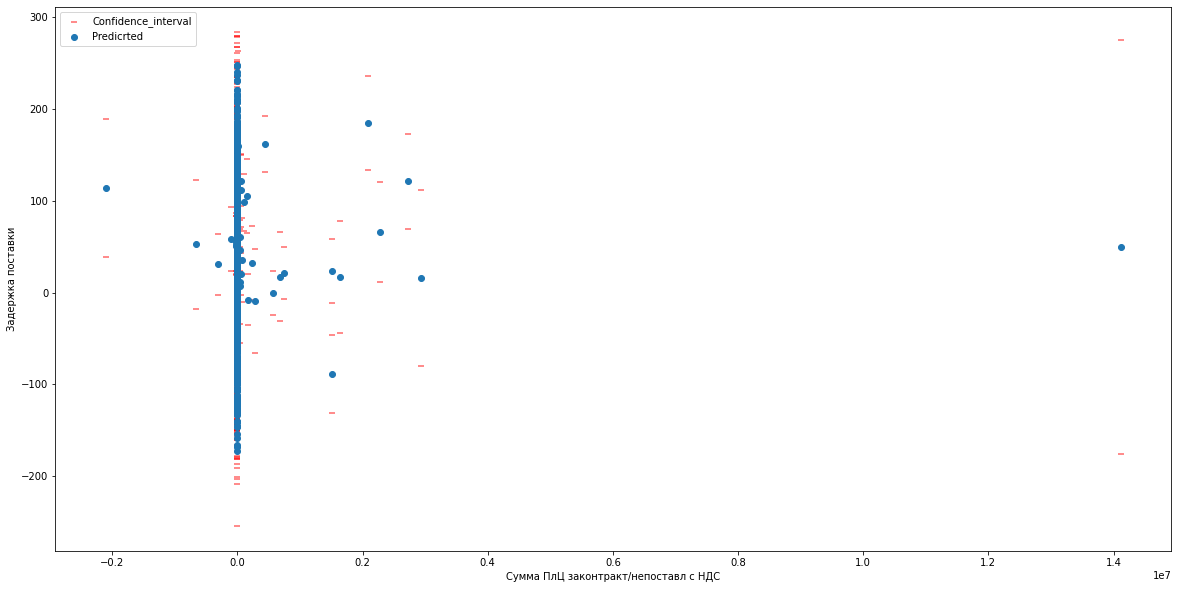

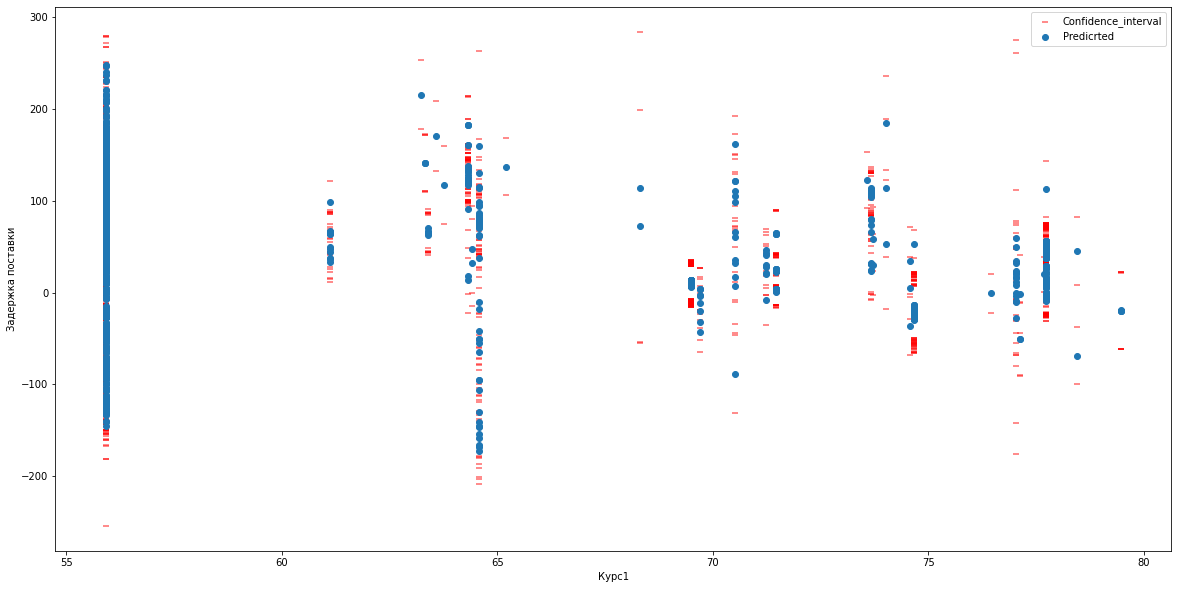

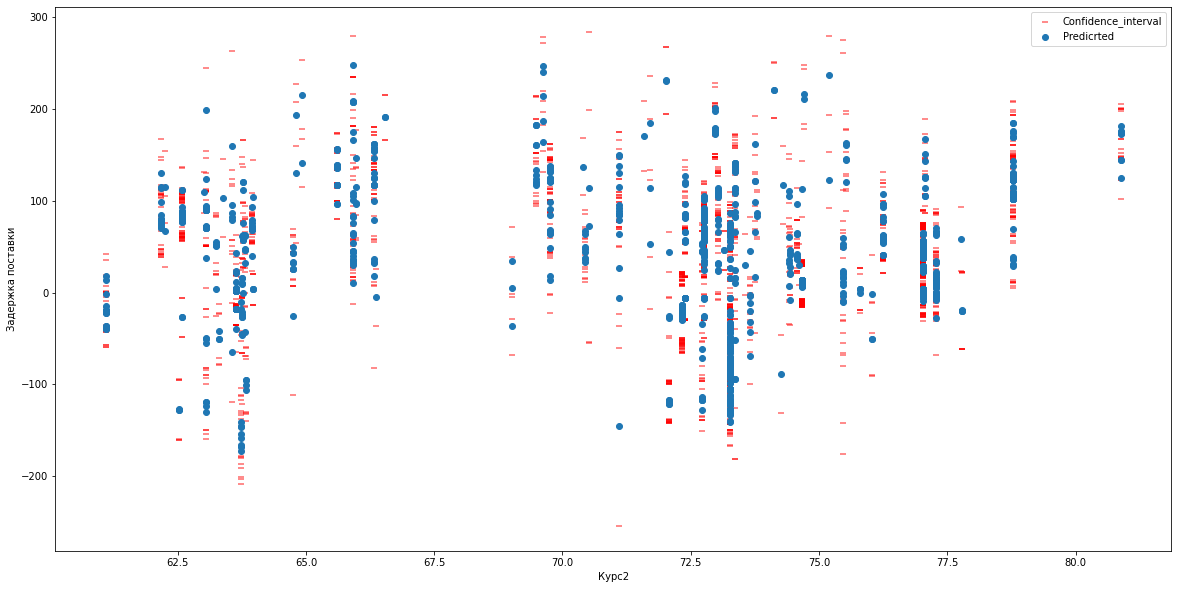

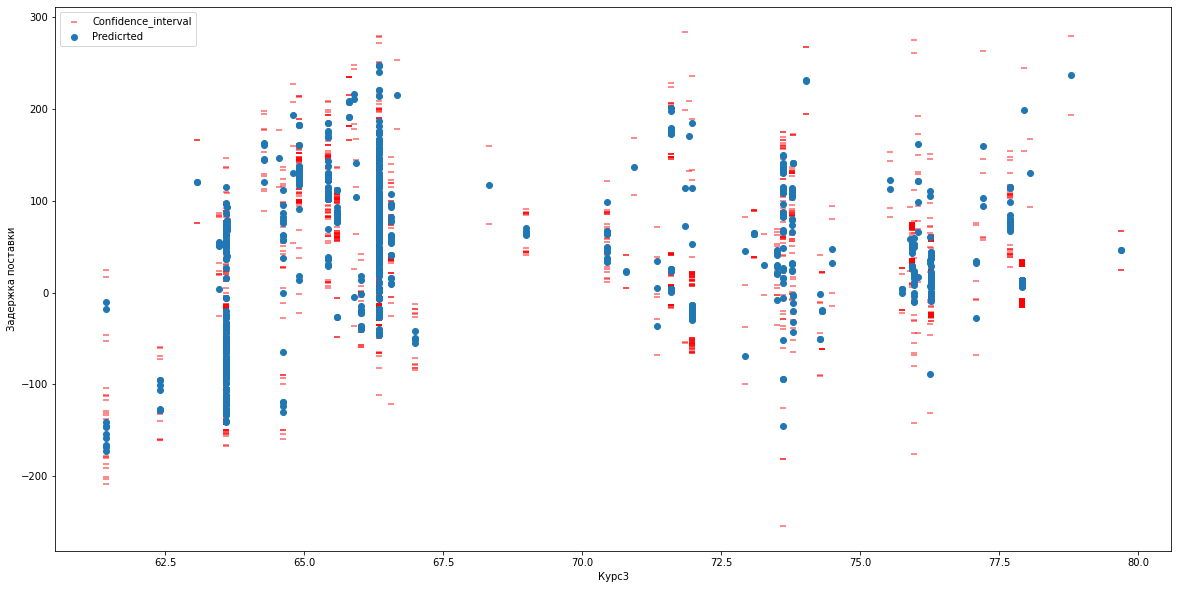

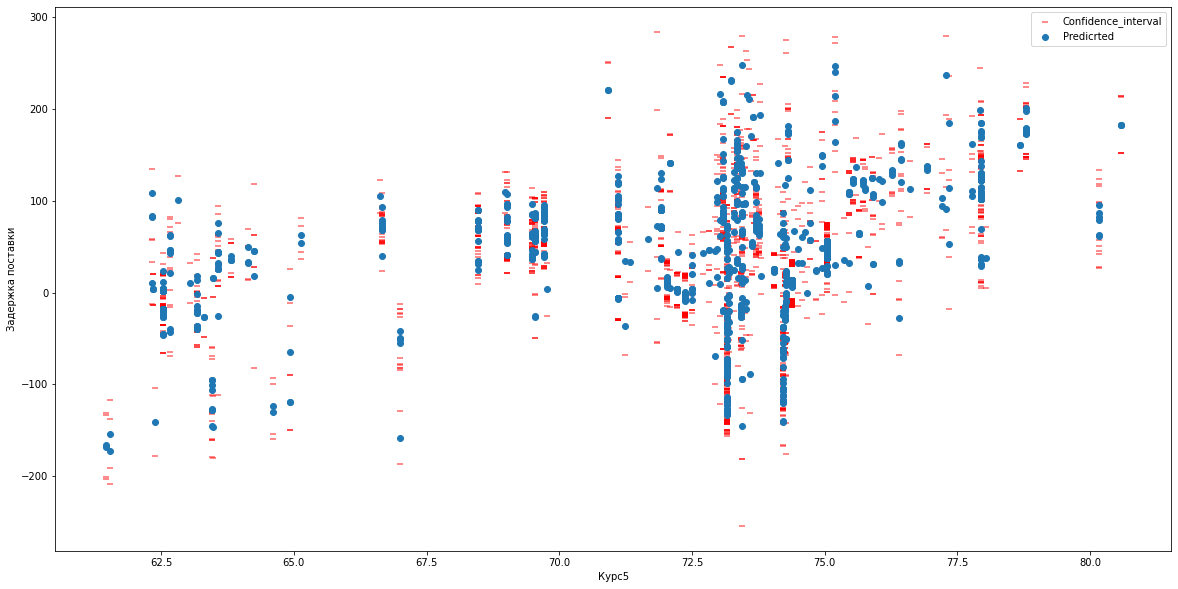

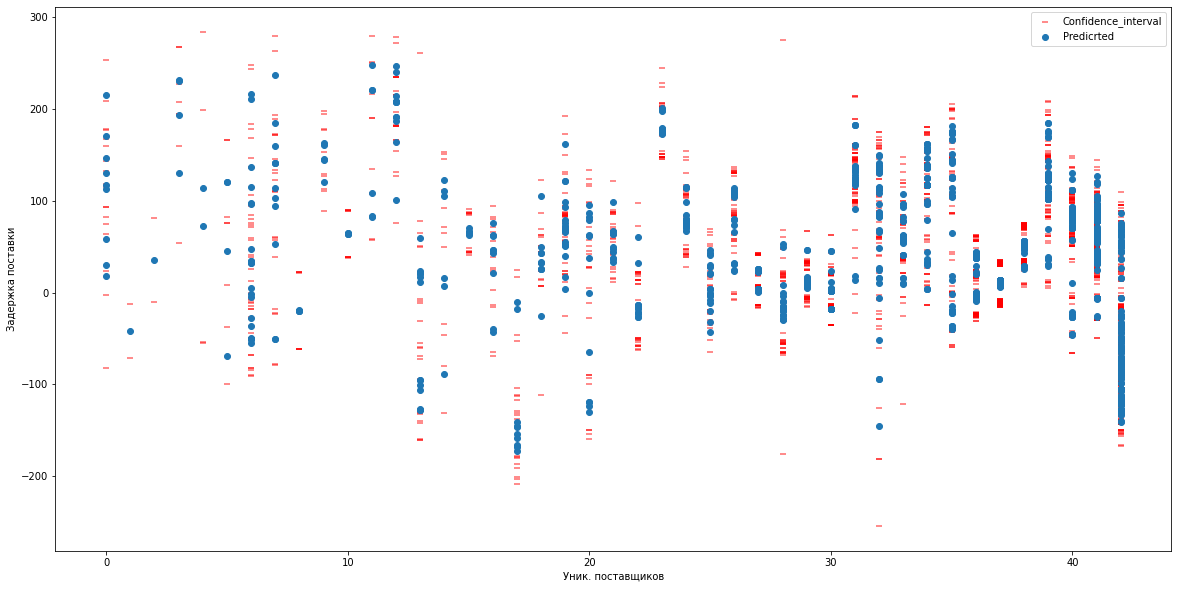

In [ ]:
i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for item in train_cols:
  plt.figure(figsize=(20,10))
  plt.scatter(X_test[item].values, plus, label = 'Confidence_interval',c = 'r',alpha=0.6, marker = "_", edgecolors ='face', plotnonfinite = True)
  plt.scatter(X_test[item].values, minus, c = 'r',alpha=0.6, marker = "_", edgecolors ='none', plotnonfinite = True)
  plt.scatter(X_test[item].values, predslr, label = 'Predicrted',alpha=1)
  #plt.scatter(X_test['Курс2'].values, y_test['Задержка поставки'].values, label = 'Реальные данные')
  plt.legend()
  plt.xlabel(item)
  plt.ylabel('Задержка поставки')

  plt.savefig('C:/Users/karpo/Downloads/РАБОТЫ/Confidence_interval/'+str(i[0])+'.png')
  plt.show()
  i.pop(0)
  if i == []:
    break

# Lasso

In [ ]:
n_alphas = 200
alphas = np.linspace(-10, 10, n_alphas)
test_score = []
train_score = []
for alpha in alphas:

  lasso = Lasso(alpha, fit_intercept=True)
  lasso.fit(X_train, y_train)
  train_score.append(lasso.score(X_train, y_train))
  test_score.append(lasso.score(X_test, y_test))

points = pd.DataFrame()
points['alphas'] = alphas.tolist()
points['test score'] = test_score
points['train_score'] = train_score
points.sort_values(by='test score', ignore_index=True, ascending=False, inplace=True)

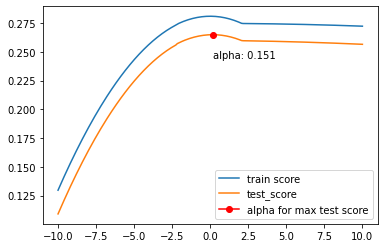

In [ ]:
plt.plot(alphas, train_score, label = 'train score')
plt.plot(alphas, test_score, label = 'test_score')
plt.plot(points['alphas'][0],points['test score'][0], '-ro', label='alpha for max test score' )
plt.text(points['alphas'][0],points['test score'][0] -0.02, 'alpha: {:.3f}'.format(points['alphas'][0]))
plt.legend()

In [ ]:
lasso = Lasso(points['alphas'][0], fit_intercept=True)
lasso.fit(X_train, y_train)
predslas = lasso.predict(X_test)
rmse = mean_squared_error(y_test,predslas,squared=False)

print('Root mean Squared Error: {:.3f}'.format(rmse))
print('Training Score: {}'.format(lasso.score(X_train, y_train)))
print('Test Score: {}'.format(lasso.score(X_test, y_test)))

Root mean Squared Error: 124.700
Training Score: 0.28084686361690714
Test Score: 0.26484145460905606


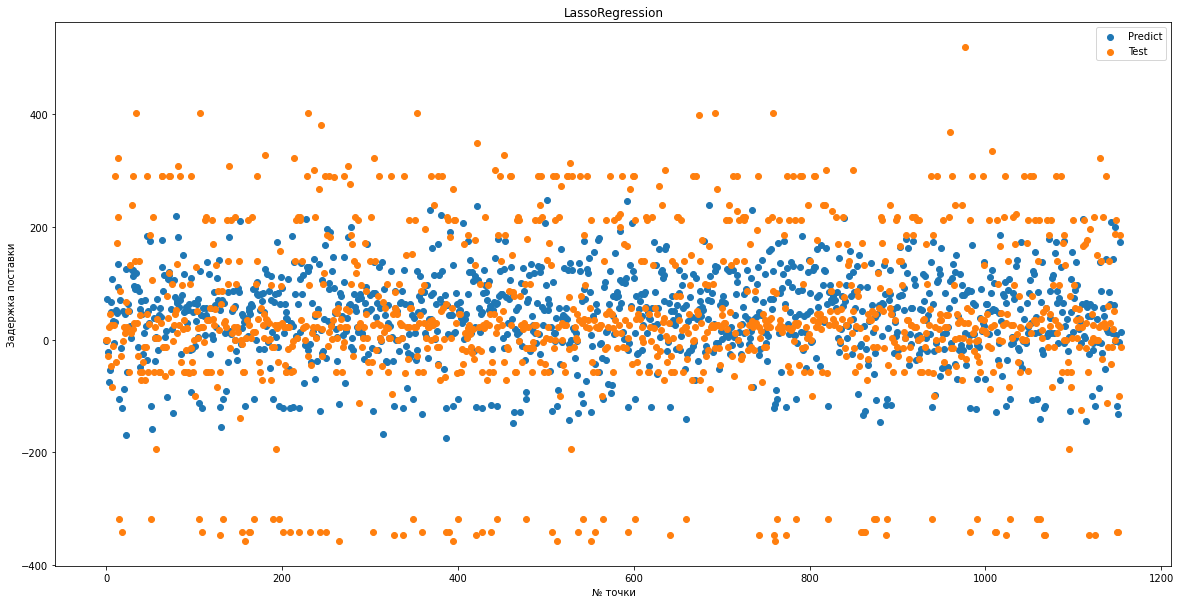

In [ ]:
x_axis = range(len(y_test))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, predslas, label='Predict')
plt.scatter(x_axis, y_test['Задержка поставки'], label='Test')

plt.xlabel('№ точки')
plt.ylabel('Задержка поставки')
plt.title('LassoRegression')
plt.legend()

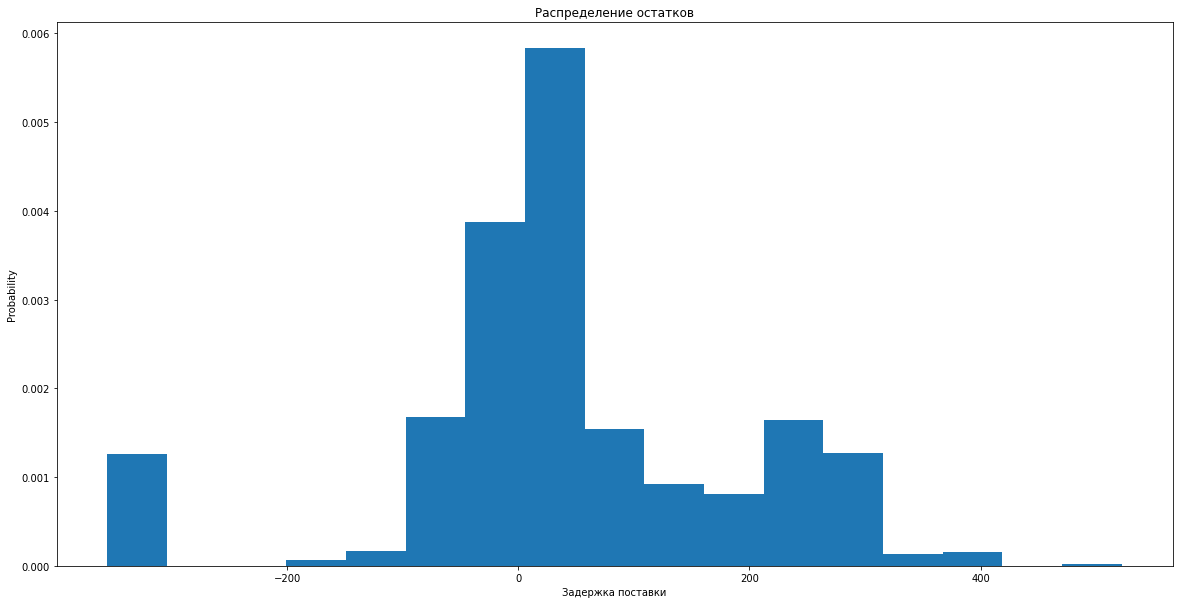

In [ ]:
distribution_of_residuals(predslas[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


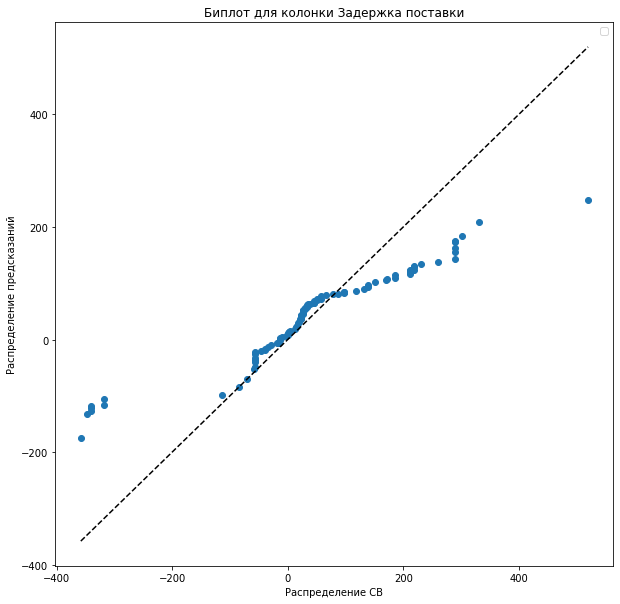

In [ ]:
quantile_biplot(y_test, 'Задержка поставки', predslas)

C:\Users\Павел\AppData\Local\Temp\ipykernel_16656\4267585464.py:3: UserWarning: You passed a edgecolor/edgecolors ('face') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[item].values, plus, label = 'Confidence_interval',c = 'r',alpha=0.6, marker = "_", edgecolors ='face', plotnonfinite = True)
C:\Users\Павел\AppData\Local\Temp\ipykernel_16656\4267585464.py:4: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[item].values, minus, c = 'r',alpha=0.6, marker = "_", edgecolors ='none', plotnonfinite = True)


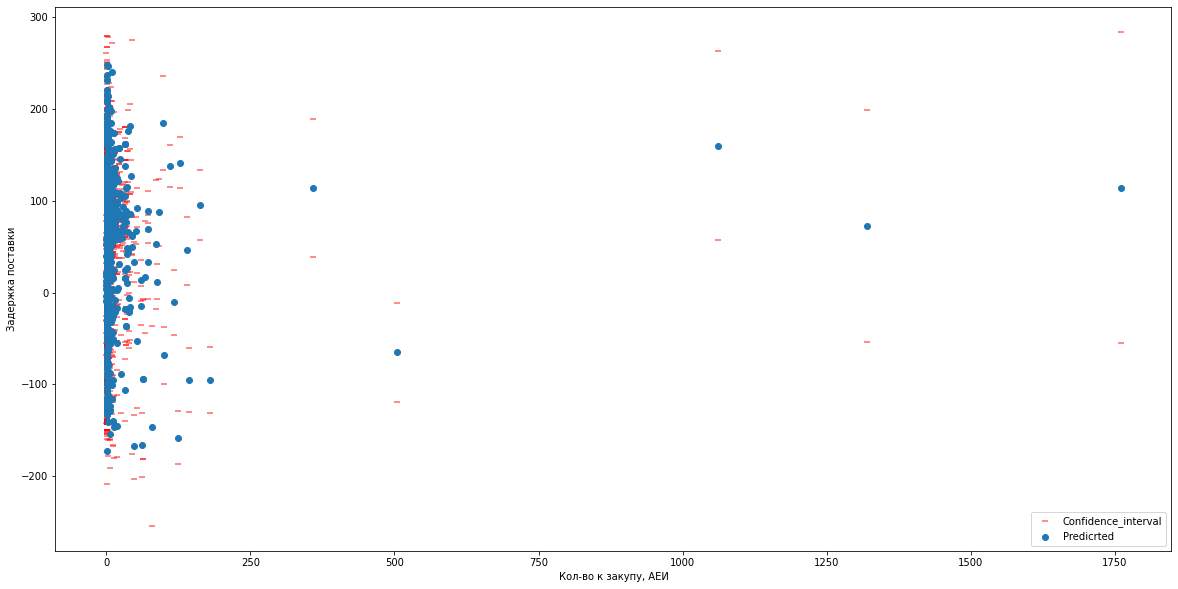

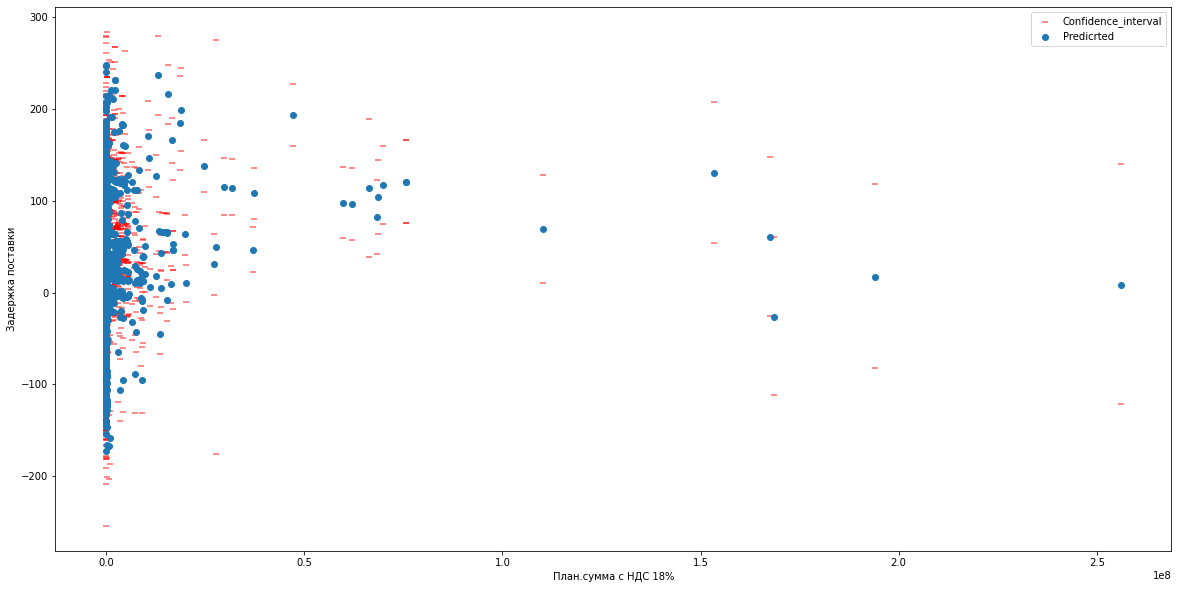

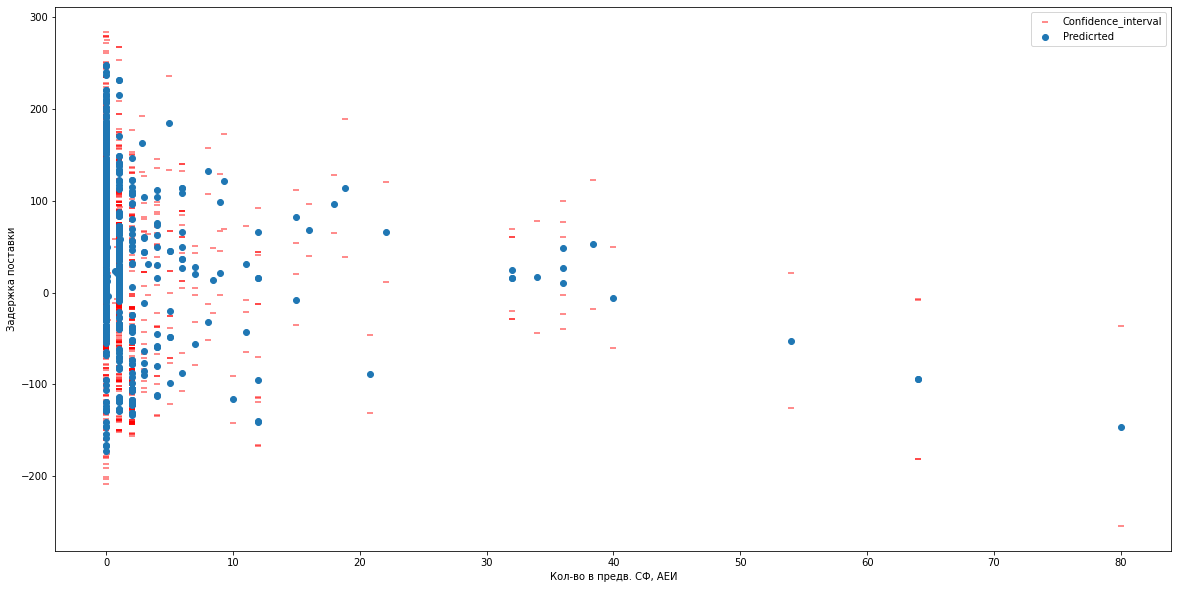

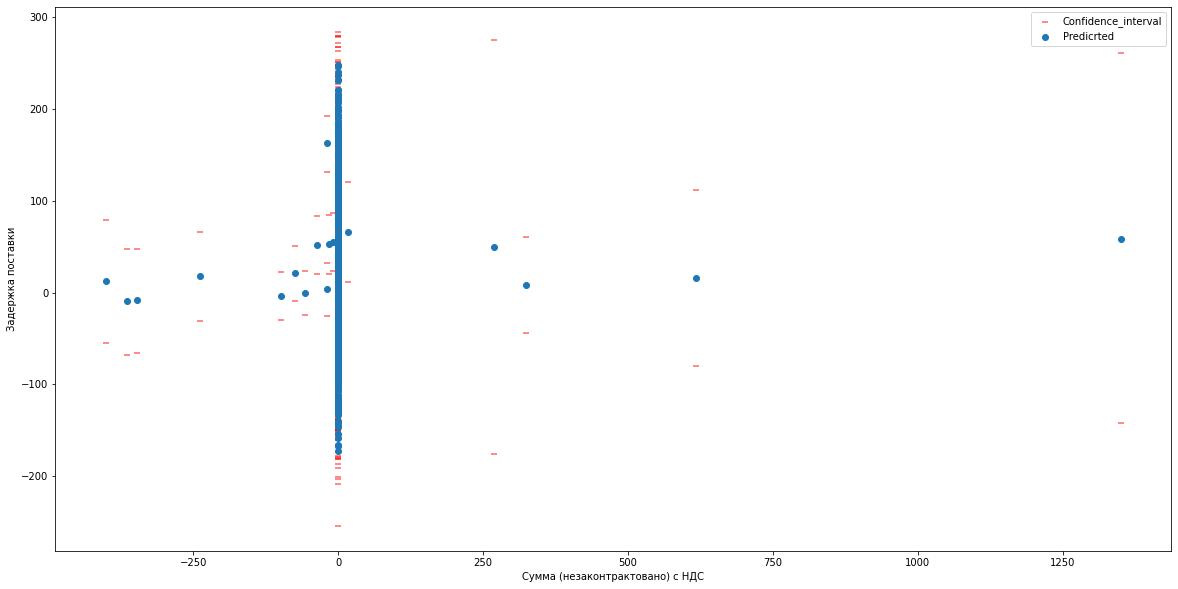

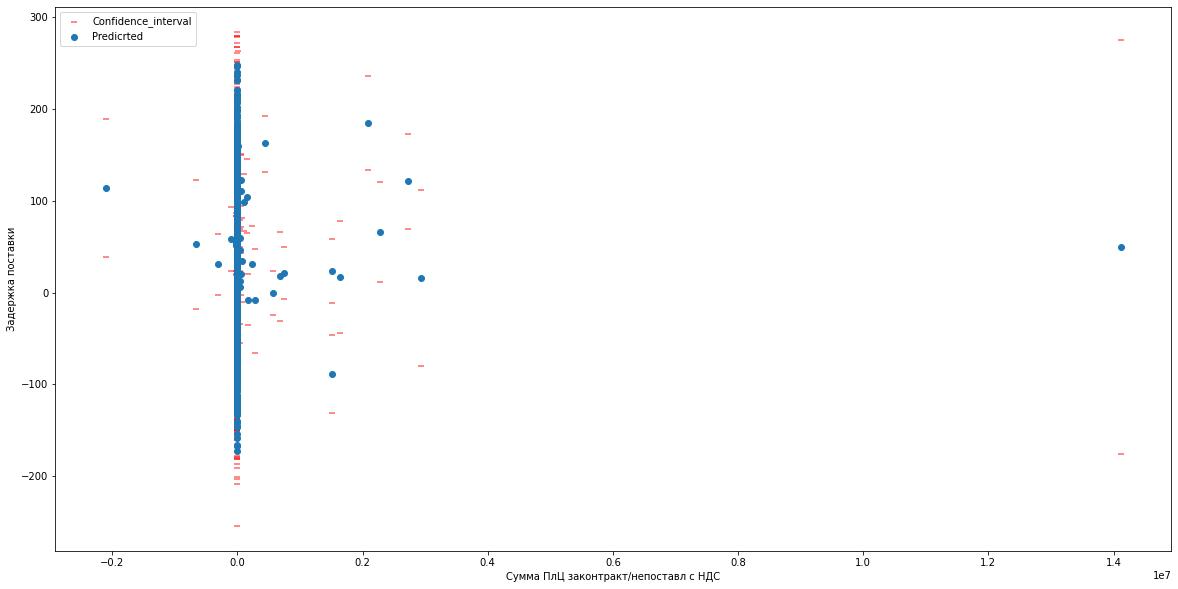

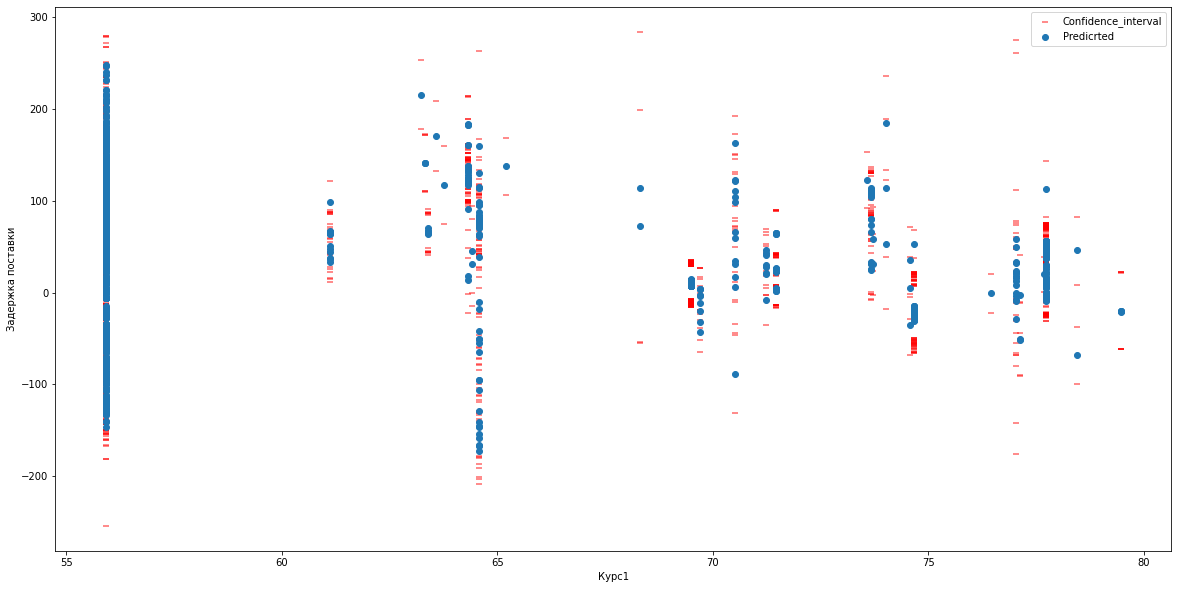

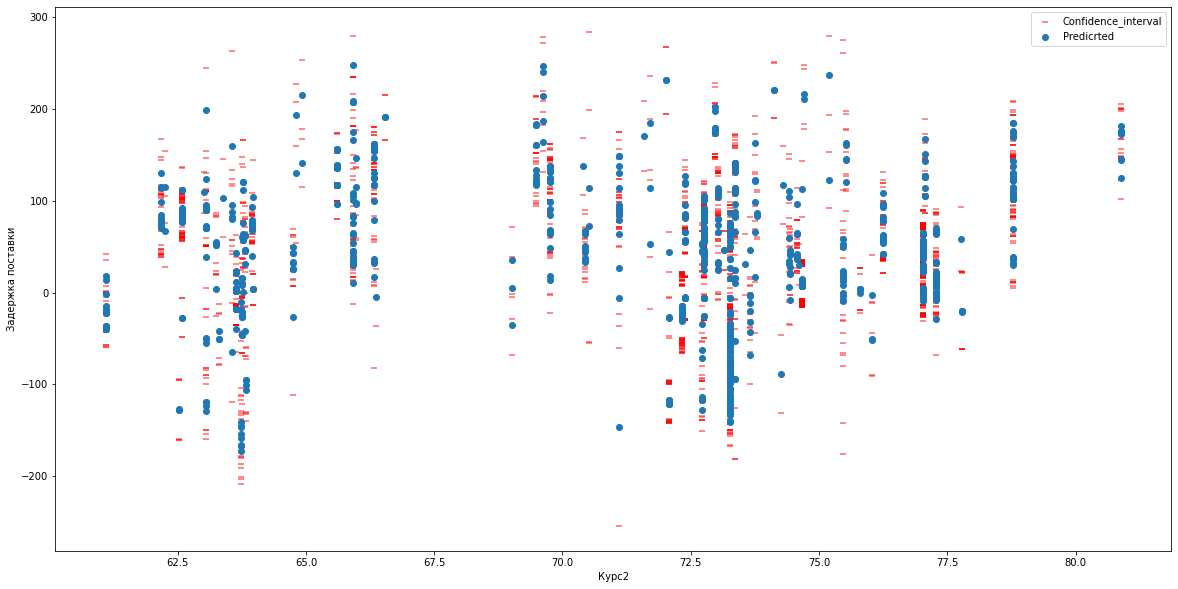

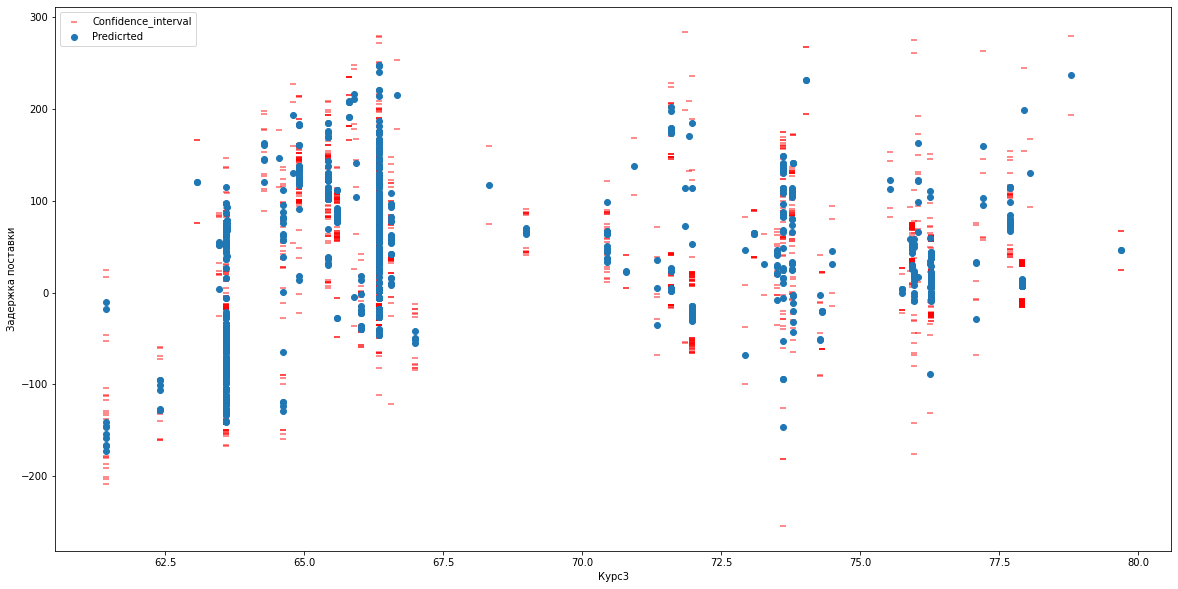

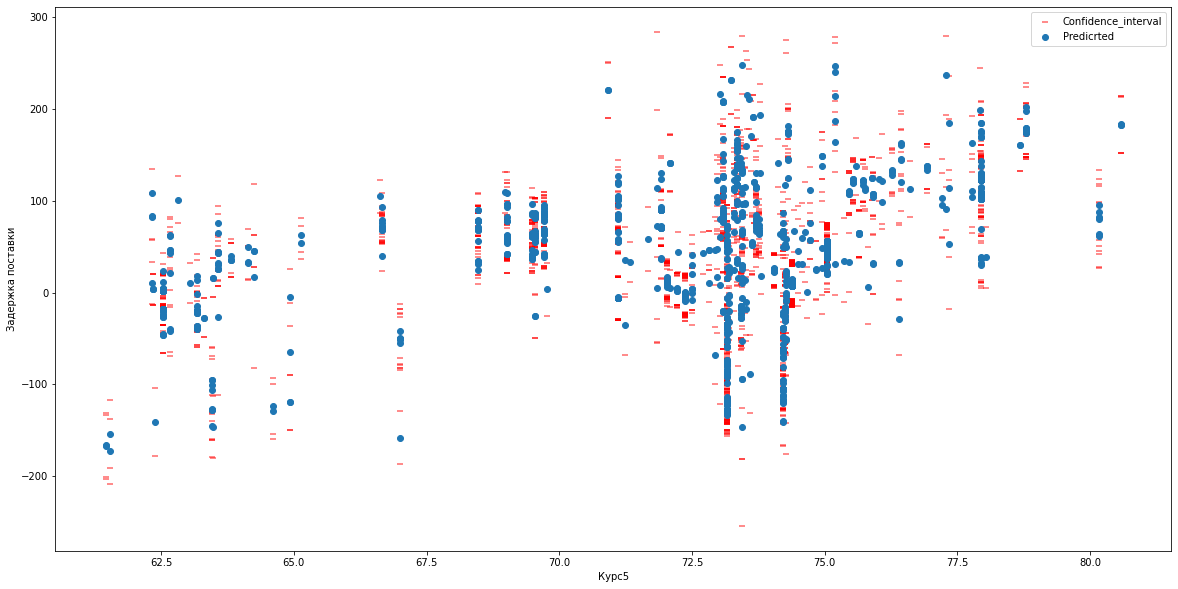

In [ ]:
for item in cont_cols:
  plt.figure(figsize=(20,10))
  plt.scatter(X_test[item].values, plus, label = 'Confidence_interval',c = 'r',alpha=0.6, marker = "_", edgecolors ='face', plotnonfinite = True)
  plt.scatter(X_test[item].values, minus, c = 'r',alpha=0.6, marker = "_", edgecolors ='none', plotnonfinite = True)
  plt.scatter(X_test[item].values, preds, label = 'Predicrted',alpha=1)
  #plt.scatter(X_test['Курс2'].values, y_test['Задержка поставки'].values, label = 'Реальные данные')
  plt.legend()
  plt.xlabel(item)
  plt.ylabel('Задержка поставки')

# Ridge

In [ ]:
n_alphas = 200
alphas = np.linspace(6, 10, n_alphas)
test_score = []
train_score = []
for alpha in alphas:

  ridge = Ridge(alpha, fit_intercept=True)
  ridge.fit(X_train, y_train)
  train_score.append(ridge.score(X_train, y_train))
  test_score.append(ridge.score(X_test, y_test))

points = pd.DataFrame()
points['alphas'] = alphas.tolist()
points['test score'] = test_score
points['train_score'] = train_score
points.sort_values(by='test score', ignore_index=True, ascending=False, inplace=True)

In [ ]:
points['test score'][0]+0.1

0.3648636223766192

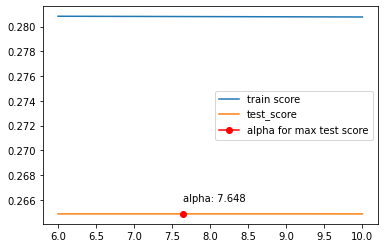

In [ ]:
plt.plot(alphas, train_score, label = 'train score')
plt.plot(alphas, test_score, label = 'test_score')
plt.plot(points['alphas'][0],points['test score'][0], '-ro', label='alpha for max test score' )
plt.text(points['alphas'][0],points['test score'][0]+0.001 , 'alpha: {:.3f}'.format(points['alphas'][0]))
plt.legend()

In [ ]:
ridge = Ridge(alpha=points['alphas'][0], fit_intercept=True)
ridge.fit(X_train, y_train)
predsridge = ridge.predict(X_test)
rmse = mean_squared_error(y_test,predsridge,squared=False)

print('Root mean Squared Error: {:.3f}'.format(rmse))
print('Training Score: {}'.format(ridge.score(X_train, y_train)))
print('Test Score: {}'.format(ridge.score(X_test, y_test)))

Root mean Squared Error: 124.698
Training Score: 0.28081741759640244
Test Score: 0.2648636223766192


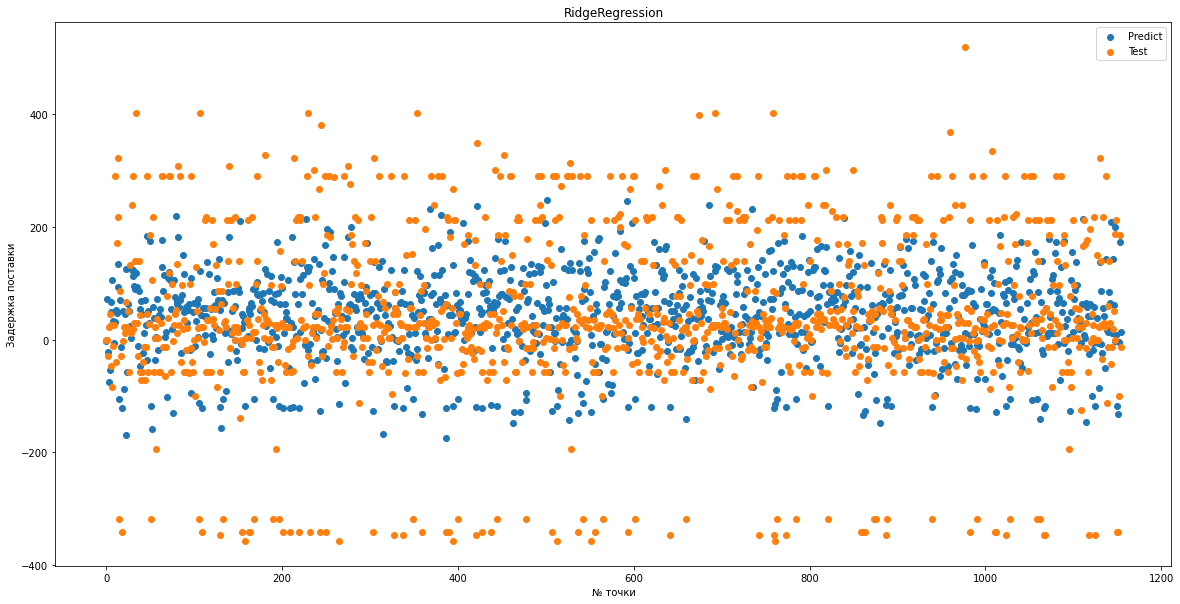

In [ ]:
x_axis = range(len(y_test))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, predsridge, label='Predict')
plt.scatter(x_axis, y_test['Задержка поставки'], label='Test')
#sns.regplot(x_axis, np.ravel(preds))
plt.xlabel('№ точки')
plt.ylabel('Задержка поставки')
plt.title('RidgeRegression')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


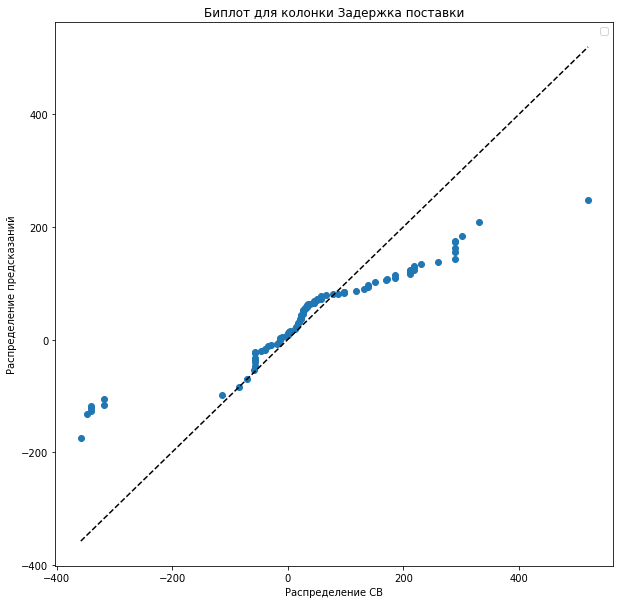

In [ ]:
quantile_biplot(y_test, 'Задержка поставки',predsridge)

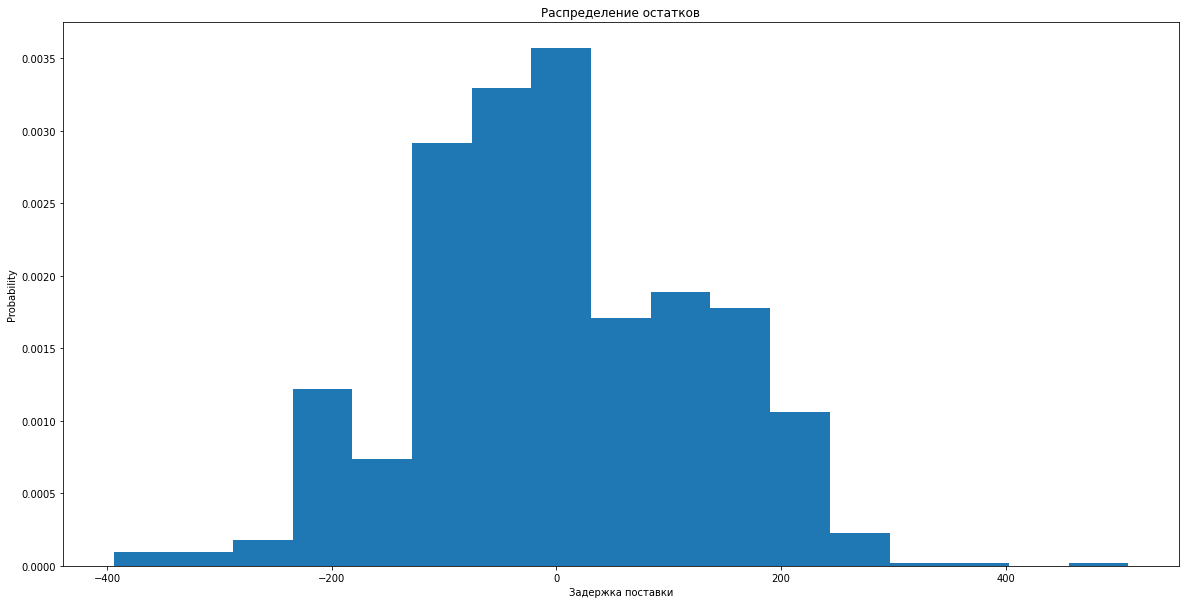

In [ ]:
distribution_of_residuals(predsridge)

# Байес 1 

In [ ]:
import bamt.Networks as Nets
import bamt.Preprocessors as pp
import bamt.Nodes as Nodes
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

In [ ]:
fp = 'C:/Users/Павел/Downloads/Telegram Desktop/данные/данные/EXPORT.xlsx' #ПК путь к датасету
data = pd.read_excel(fp)
#data.drop_duplicates(subset=['Дата ФП по последней входящей поставке','Дата заявки', 'Поставщик'], inplace=True, ignore_index=True)
drop_cols = ['Кол-во в Заказах, АЕИ', 'Клиент','Тип финансирования', 'Сумма заказов с НДС', 'Тонаж по планам МТО', 'Рекв.Грузополучателя', 'Кол-во в СФ, АЕИ','СПП элемент','Статус плана МТО','Дата Сч/ф','Курс4', 'Сумма по Сч/ф с НДС (поставлено)', 'Поступило на ЦС, АЕИ','Шаг корр. ЭСД']

dates = ["Дата заявки", "Дата поставки по приложению", "Дата приложения" ,"ПервоначДатаПоставки (план МТО)","Прогнозная дата поставки" ,"Срок поставки","ПервоначДатаУтвПлМТО","Дата ФП по последней входящей поставке"]
data.sort_values(by = 'Прогнозная дата поставки', ignore_index= True, inplace = True)
data.drop([0,1,2,3,4,5,6], axis = 0 ,inplace = True)
data.drop(drop_cols, axis = 1 ,inplace = True)

data.fillna(0, inplace=True)


period = data['Дата ФП по последней входящей поставке'] - data['Прогнозная дата поставки']
data['Задержка поставки'] = period
data['Задержка поставки'] = data['Задержка поставки'].dt.days
data = data.astype({'Задержка поставки': np.float}, copy=False)

data.reset_index(drop=True ,inplace = True)
data.drop(dates, axis = 1 ,inplace = True)

data = data[(data['Кол-во к закупу, АЕИ'] < 25000) & (data['План.сумма с НДС 18%'] < 3*10**8) & (data['Кол-во в предв. СФ, АЕИ'] < 100) & (data['Сумма (незаконтрактовано) с НДС'] > -500) & (data['Сумма (незаконтрактовано) с НДС'] < 2000) & (data['Сумма ПлЦ законтракт/непоставл с НДС'] < 3*10**7)]

x = data['Поставщик'].value_counts()
x = x.to_frame(name= 'Уник. поставщиков')
x.reset_index(inplace=True)
x.rename(columns={"index": 'Поставщик'}, inplace=True)

data = data.merge(x, on='Поставщик' )
data = data[data['Уник. поставщиков']>1]

data = data.astype({'Гр.зак.': str, 'Материал':str, 'Поставщик':str,'Код класса МТР':str, 'Уник. поставщиков':str,'Шаг ЭСД':str }, copy=False)

In [ ]:
disc_cols = ['Гр.зак.', 'Материал', 'Поставщик','Код класса МТР', 'Шаг ЭСД']
cont_cols = data.columns.values.tolist()
for item in disc_cols:
  cont_cols.remove(item)
cont_cols.remove('Задержка поставки')

In [ ]:
target_cols = ['Задержка поставки']
train_cols = data.columns.values.tolist()
train_cols.remove('Задержка поставки')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[train_cols], data[target_cols], random_state=42, test_size=0.3, stratify=data['Поставщик'])

In [ ]:
X_train['Задержка поставки'] = y_train
X_train.reset_index(drop=True, inplace = True)
#X_test['Задержка поставки'] = y_test

In [ ]:
best_edges = [('Шаг ЭСД', 'Гр.зак.'),
 ('Материал', 'Гр.зак.'),
 ('Код класса МТР', 'Гр.зак.'),
 ('Шаг ЭСД', 'Материал'),
 ('Шаг ЭСД', 'Поставщик'),
 ('Материал', 'Поставщик'),
 ('Код класса МТР', 'Поставщик'),
 ('Код класса МТР', 'Кол-во к закупу, АЕИ'),
 ('Кол-во в предв. СФ, АЕИ', 'Кол-во к закупу, АЕИ'),
 ('Шаг ЭСД', 'Код класса МТР'),
 ('Материал', 'Код класса МТР'),
 ('Гр.зак.', 'План.сумма с НДС 18%'),
 ('Уник. поставщиков', 'План.сумма с НДС 18%'),
 ('Кол-во в предв. СФ, АЕИ', 'План.сумма с НДС 18%'),
 ('Сумма (незаконтрактовано) с НДС', 'Кол-во в предв. СФ, АЕИ'),
 ('Шаг ЭСД', 'Сумма (незаконтрактовано) с НДС'),
 ('Материал', 'Сумма ПлЦ законтракт/непоставл с НДС'),
 ('Уник. поставщиков', 'Сумма ПлЦ законтракт/непоставл с НДС'),
 ('Кол-во в предв. СФ, АЕИ', 'Сумма ПлЦ законтракт/непоставл с НДС'),
 ('Шаг ЭСД', 'Уник. поставщиков'),
 ('Материал', 'Уник. поставщиков'),
 ('Код класса МТР', 'Уник. поставщиков'),
 ('Гр.зак.', 'Задержка поставки'),
 ('Уник. поставщиков', 'Задержка поставки'),
 ('Кол-во в предв. СФ, АЕИ', 'Задержка поставки')]

In [ ]:
params = {'init_nodes':['Курс1','Курс2','Курс3','Курс5'],
          'init_edges': best_edges,
          'remove_init_edges':True}
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(X_train)
bn = Nets.HybridBN(has_logit=False, use_mixture=True)# init BN
info = p.info
bn.add_nodes(info)
bn.add_edges(discretized_data,  scoring_function=('MI',), params=params)

bn.fit_parameters(X_train)
bn.plot('BN1.html')

In [ ]:
test = X_train[['Гр.зак.', 'Материал', 'Поставщик', 'Кол-во к закупу, АЕИ',
       'Код класса МТР', 'План.сумма с НДС 18%', 'Шаг ЭСД' ,
       'Кол-во в предв. СФ, АЕИ', 'Сумма (незаконтрактовано) с НДС',
       'Сумма ПлЦ законтракт/непоставл с НДС', 'Курс1', 'Курс2', 'Курс3',
       'Курс5', 'Уник. поставщиков']]

In [ ]:
val_pred = bn.predict(test)

In [ ]:
val_pred1 = bn.predict(X_test)


In [ ]:
df = pd.DataFrame(val_pred1)
df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
df['true'] = y_test['Задержка поставки']

df.dropna(axis=0, inplace=True)

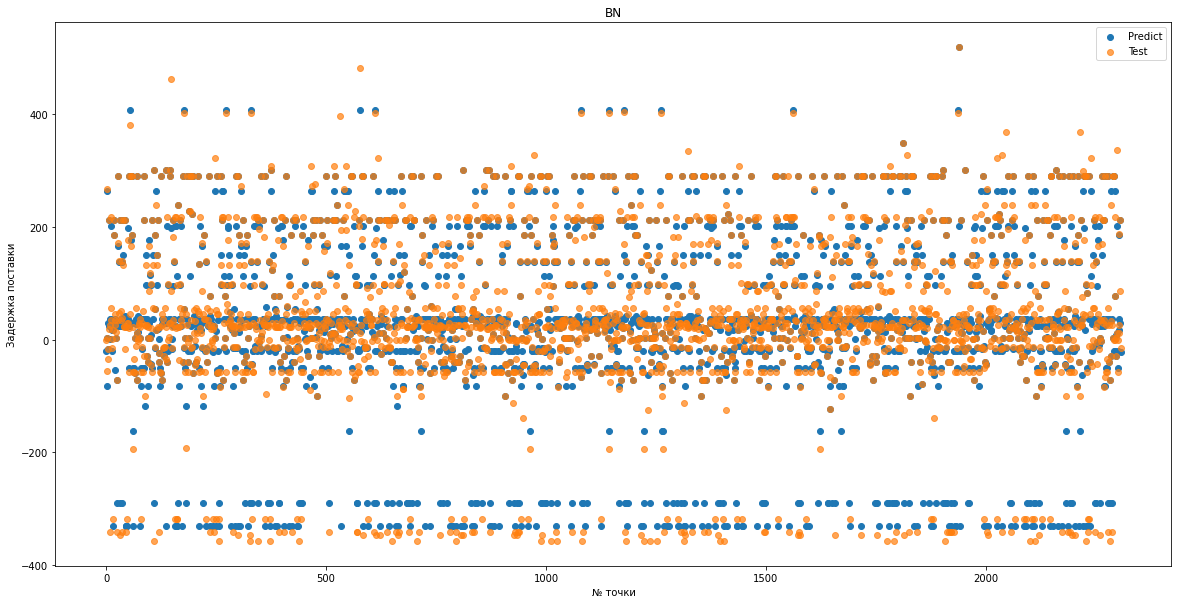

In [ ]:
x_axis = range(len(X_train['Задержка поставки']))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, val_pred['Задержка поставки'], label='Predict')
plt.scatter(x_axis, X_train['Задержка поставки'], label='Test',alpha=0.7)
plt.xlabel('№ точки')
plt.ylabel('Задержка поставки')
plt.title('BN')
plt.legend()

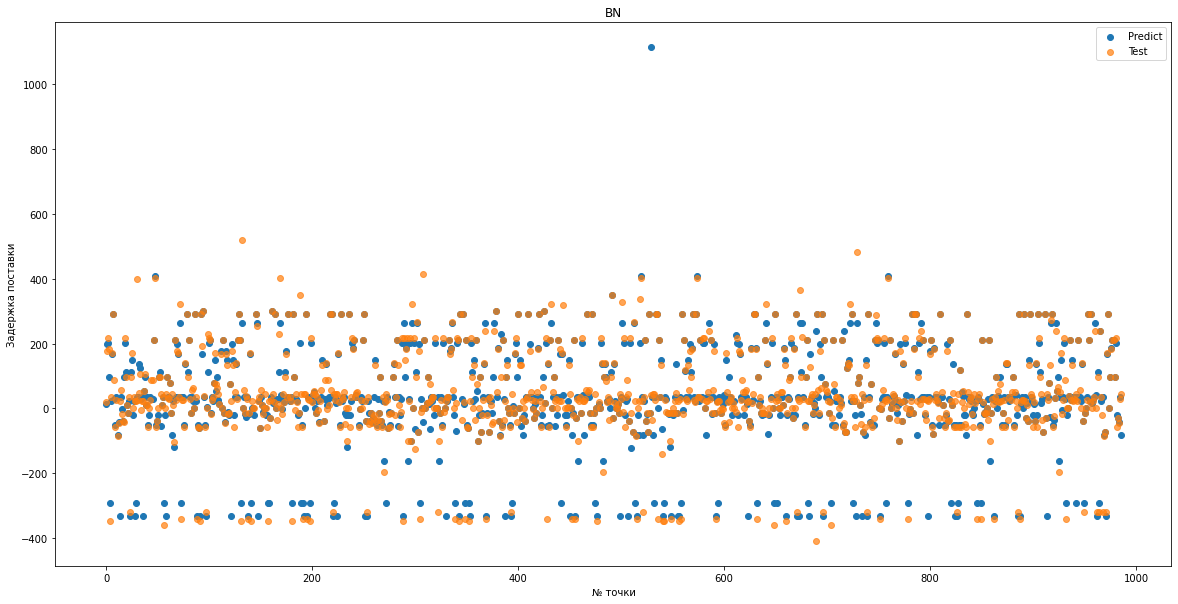

In [ ]:
x_axis = range(len(df['Задержка поставки']))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, df['Задержка поставки'].values, label='Predict')
plt.scatter(x_axis, df['true'].values, label='Test',alpha=0.7)
plt.xlabel('№ точки')
plt.ylabel('Задержка поставки')
plt.title('BN')
plt.legend()

In [ ]:
print('Root mean Squared Error test: {}'.format(mean_squared_error(df['true'].values, df['Задержка поставки'], squared=False)))
print('Training Score: {}'.format(r2_score(y_train, val_pred['Задержка поставки'])))
print('Test Score: {}'.format(r2_score(df['true'].values, df['Задержка поставки'].values)))


Root mean Squared Error test: 94.03786836611003
Training Score: 0.7005048364003494
Test Score: 0.5780523074403483


In [ ]:
sample = bn.sample(2308)


100%|█████████████████████████████████████████████████████████████████████████████| 2308/2308 [00:20<00:00, 111.63it/s]


In [ ]:
sample = sample[(sample['Задержка поставки'] < np.max(X_train['Задержка поставки'])) & (sample['Задержка поставки'] > np.min(X_train['Задержка поставки']))]

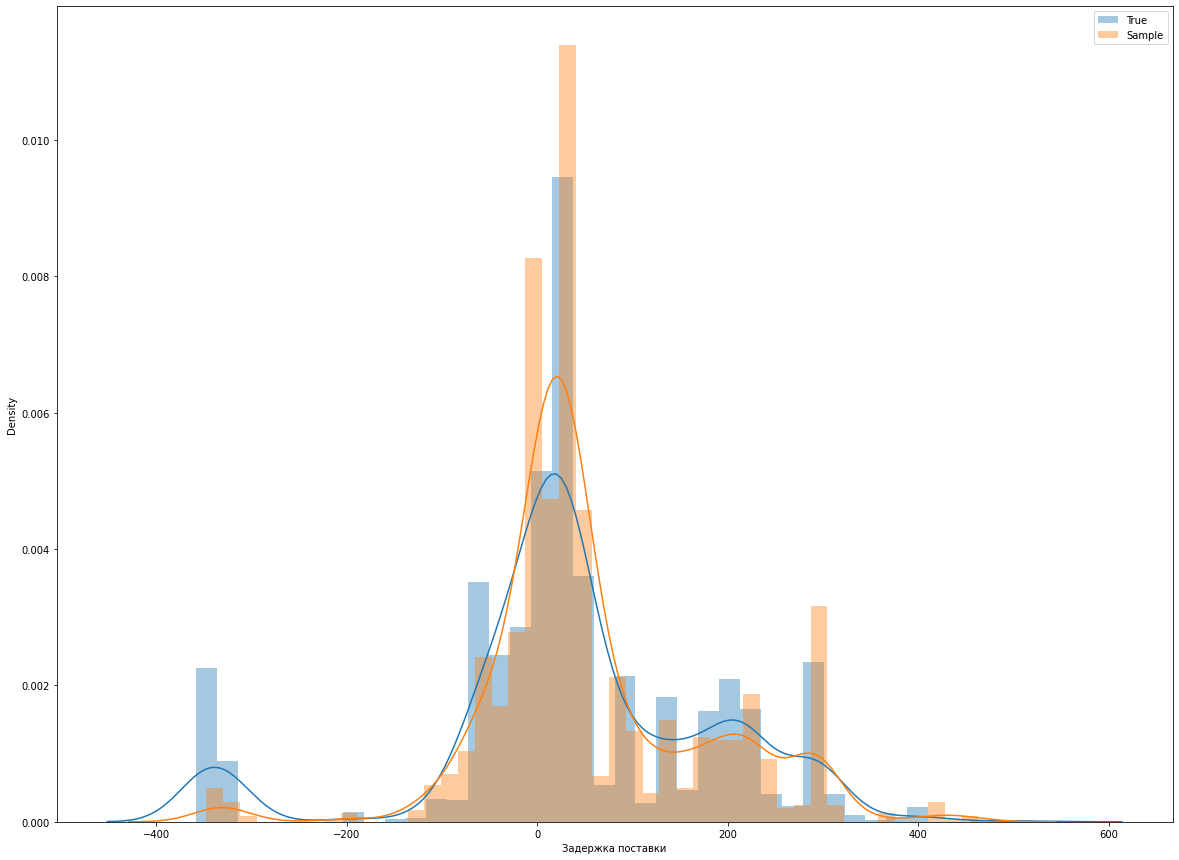

In [ ]:
plt.figure(figsize=(20,15))
sns.distplot(X_train['Задержка поставки'], label='True')
sns.distplot(sample['Задержка поставки'], label='Sample')
#plt.xlim(-600,600)
plt.legend()

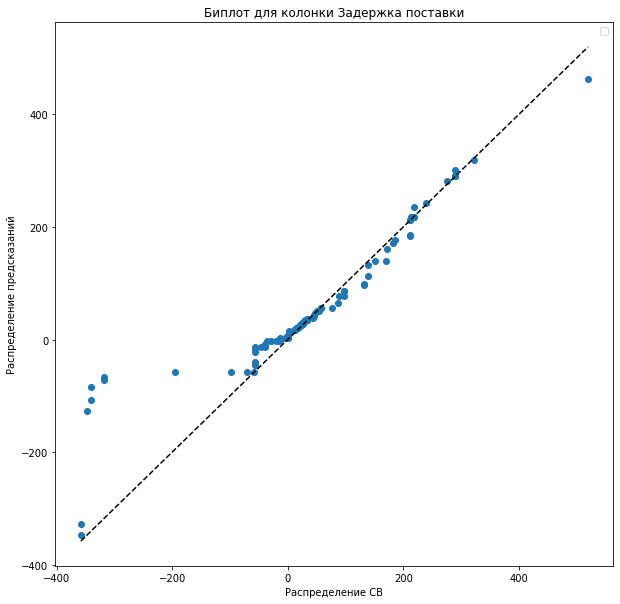

In [ ]:
quantile_biplot(y_train, 'Задержка поставки',sample['Задержка поставки'])

# Байес 2 

In [ ]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(X_train)
bn2 = Nets.HybridBN(has_logit=True)# init BN
info = p.info
bn2.add_nodes(info)
bn2.add_edges(discretized_data,  scoring_function=('MI',))

bn2.fit_parameters(X_train)
bn2.plot('BN2.html')

In [ ]:
val_pred = bn2.predict(test)

In [ ]:
val_pred1 = bn2.predict(X_test)

100%|███████████████████████████████████████████████████████████████████████████████| 990/990 [00:08<00:00, 113.56it/s]


In [ ]:
import inspect
lines = inspect.getsource(bn.predict)
print(lines)

In [ ]:
df = pd.DataFrame(val_pred1)
df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
df['true'] = y_test['Задержка поставки']

df.dropna(axis=0, inplace=True)

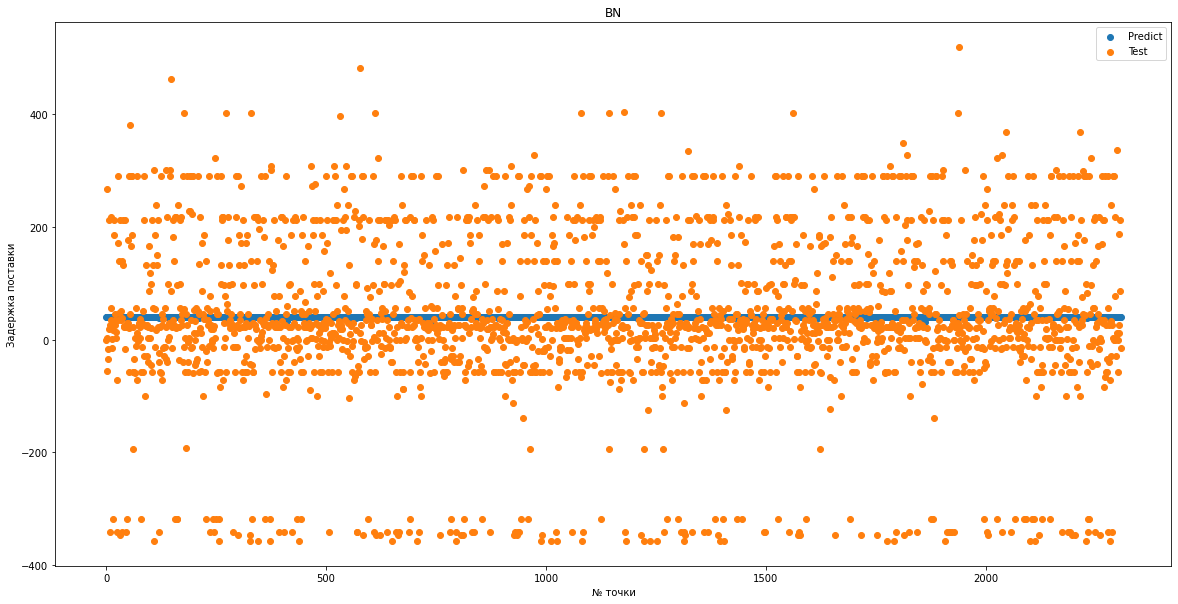

In [ ]:
x_axis = range(len(X_train['Задержка поставки']))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, val_pred['Задержка поставки'], label='Predict')
plt.scatter(x_axis, X_train['Задержка поставки'], label='Test')
plt.xlabel('№ точки')
plt.ylabel('Задержка поставки')
plt.title('BN')
plt.legend()

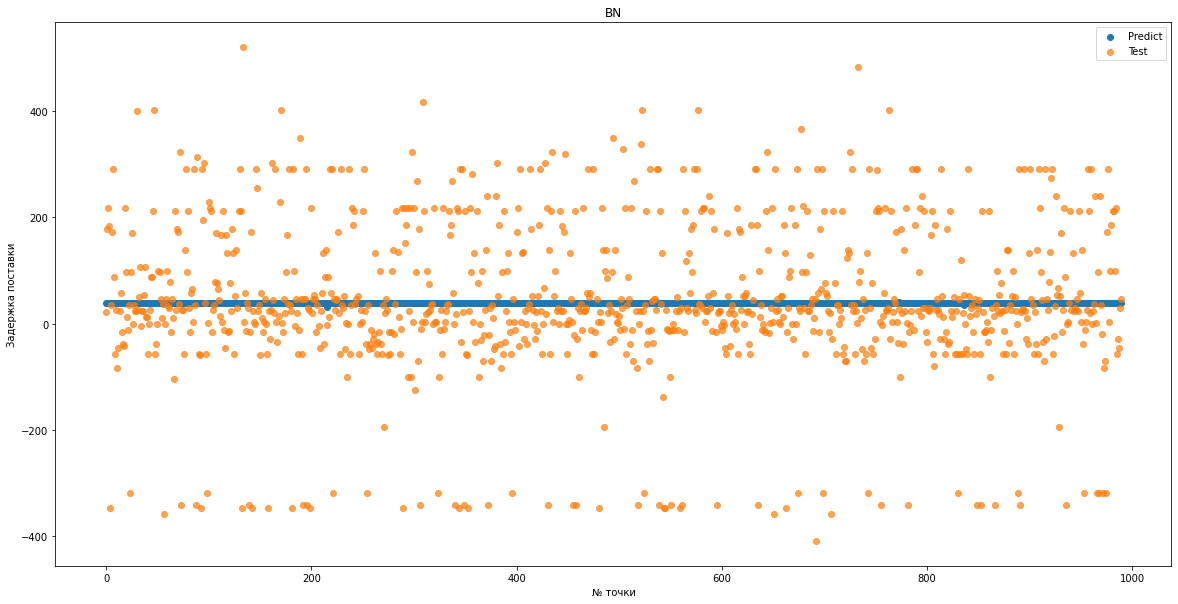

In [ ]:
x_axis = range(len(df['Задержка поставки']))
plt.figure(figsize=(20,10))
plt.scatter(x_axis, df['Задержка поставки'].values, label='Predict')
plt.scatter(x_axis, df['true'].values, label='Test',alpha=0.7)
plt.xlabel('№ точки')
plt.ylabel('Задержка поставки')
plt.title('BN')
plt.legend()

In [ ]:
print('Root mean Squared Error test: {}'.format(mean_squared_error(df['true'].values, df['Задержка поставки'], squared=False)))
print('Training Score: {}'.format(r2_score(y_train, val_pred['Задержка поставки'])))
print('Test Score: {}'.format(r2_score(df['true'].values, df['Задержка поставки'].values)))

Root mean Squared Error test: 144.9918790666092
Training Score: 4.907408683640924e-06
Test Score: -0.0005194663189074245


In [ ]:
sample = bn2.sample(5000)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 449.08it/s]


In [ ]:
sample = sample[(sample['Задержка поставки'] < np.max(X_train['Задержка поставки'])) & (sample['Задержка поставки'] > np.min(X_train['Задержка поставки']))]

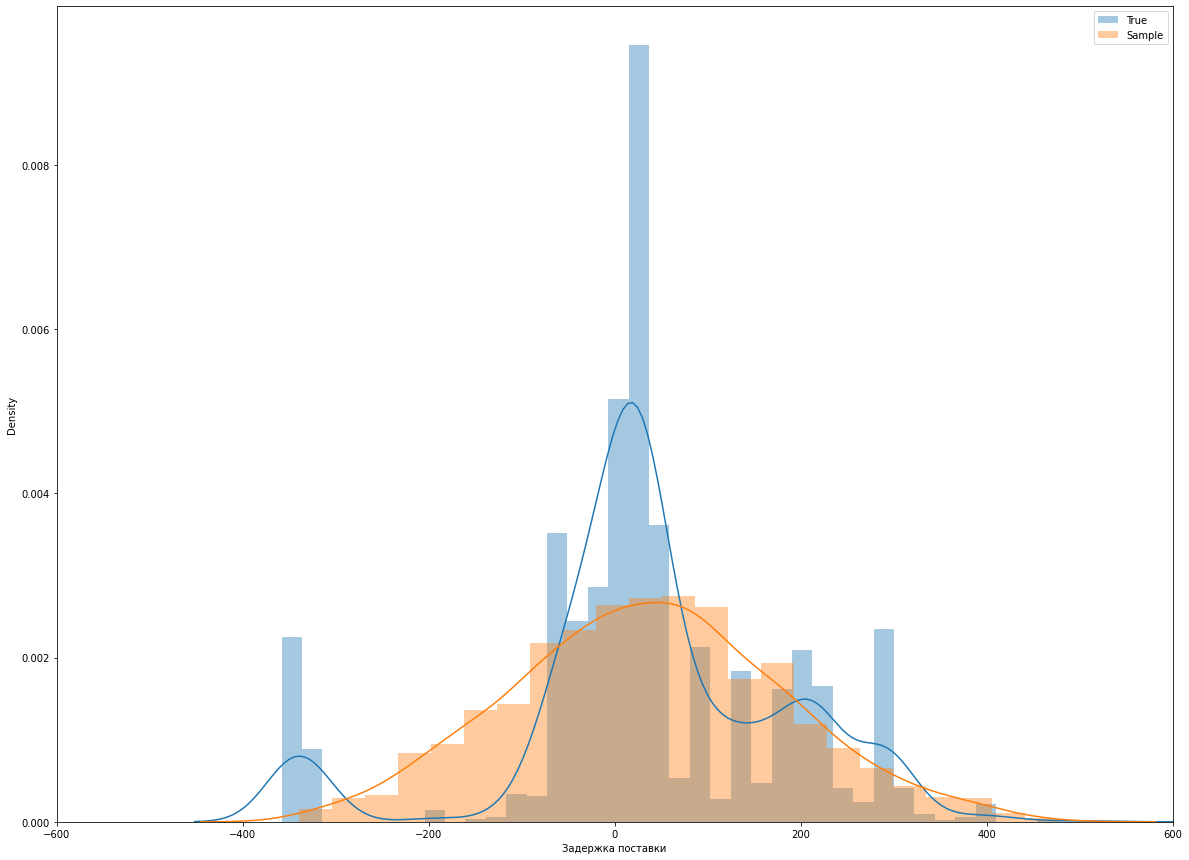

In [ ]:
plt.figure(figsize=(20,15))
sns.distplot(X_train['Задержка поставки'], label='True')
sns.distplot(sample['Задержка поставки'], label='Sample')
plt.xlim(-600,600)
plt.legend()

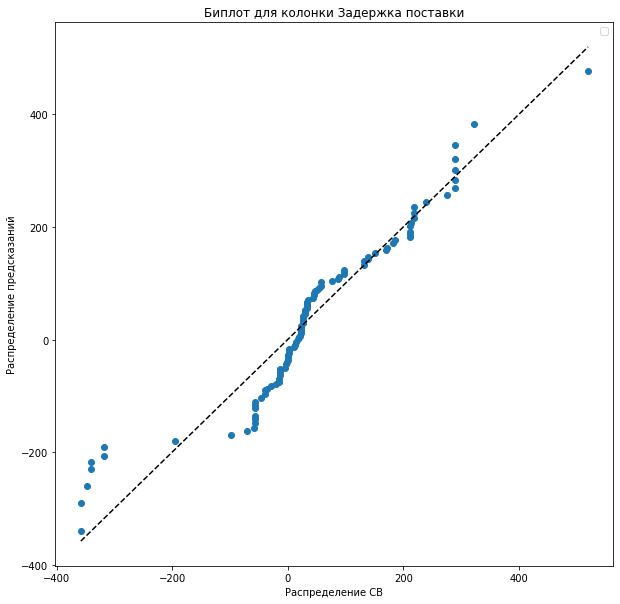

In [ ]:
quantile_biplot(y_train, 'Задержка поставки',sample['Задержка поставки'])